In [20]:
pd.read_csv('complete_data_bibliometrics_with_all_diseases_biobert_svm_prediction_updated.tsv',sep='\t').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476 entries, 0 to 3475
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             3476 non-null   int64  
 1   id1               3476 non-null   object 
 2   id2               3476 non-null   object 
 3   is_in_same_sent   2629 non-null   object 
 4   min_sents_window  2629 non-null   float64
 5   sentence          3476 non-null   object 
 6   in_neighbors      2629 non-null   object 
 7   label             3476 non-null   int64  
 8   hindex            3474 non-null   object 
 9   year              3476 non-null   float64
 10  citations         3474 non-null   float64
 11  journal           3476 non-null   object 
 12  disease           3476 non-null   object 
 13  Unnamed: 0        1674 non-null   float64
 14  Symbol            1674 non-null   object 
 15  Prediction        827 non-null    float64
 16  year_diff         827 non-null    float64


Loading Data...
  📖 Loading Unified Text Data: /data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/complete_data_bibliometrics_with_all_diseases_biobert_svm_prediction_updated.tsv
  ⚠️ Dropped 4 rows due to missing values (matching Script 2).
Causal
0.85
Not causal
Not causal
Causal
0.85
Causal
0.85
Not causal
Causal
0.85
Causal
0.85
Causal
0.75
Not causal
Causal
0.85
Causal
0.91
Causal
0.85
Causal
0.85
Causal
0.85
Causal
0.75
Not causal
Causal
0.85
Causal
0.78
Causal
0.92
Causal
0.7
Causal
0.85
Causal
0.92
Not causal
Causal
0.85
Causal
0.85
Not causal
Not causal
Not causal
Causal
0.85
Causal
0.85
Causal
0.85
Causal
0.85
Not causal
Causal
0.92
Not causal
Causal
0.75
Causal
0.85
Causal
0.85
Causal
0.78
Causal
0.85
Causal
0.85
Causal
0.75
Causal
0.85
Not causal
Causal
0.85
Causal
0.82
Not causal
Causal
0.8
Not causal
Causal
0.85
Causal
0.92
Causal
0.85
Causal
0.85
Not causal
Not causal
Not causal
Causal
0.85
Causal
0.9
Not causal
Causal
0.85
Not c

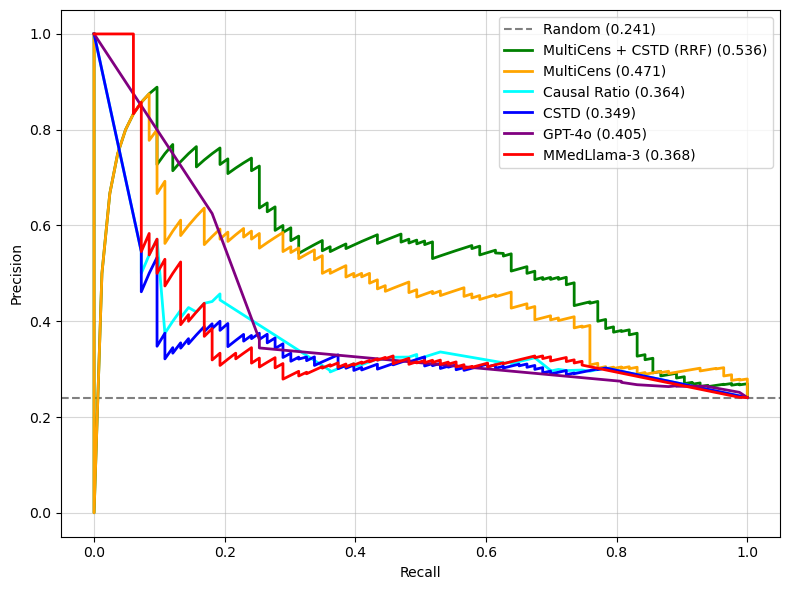


   💾 Saved PR curve to: /data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/multicens_v17_fixed_results/precision_recall_curve.png

Generating Recall @ K Curve...


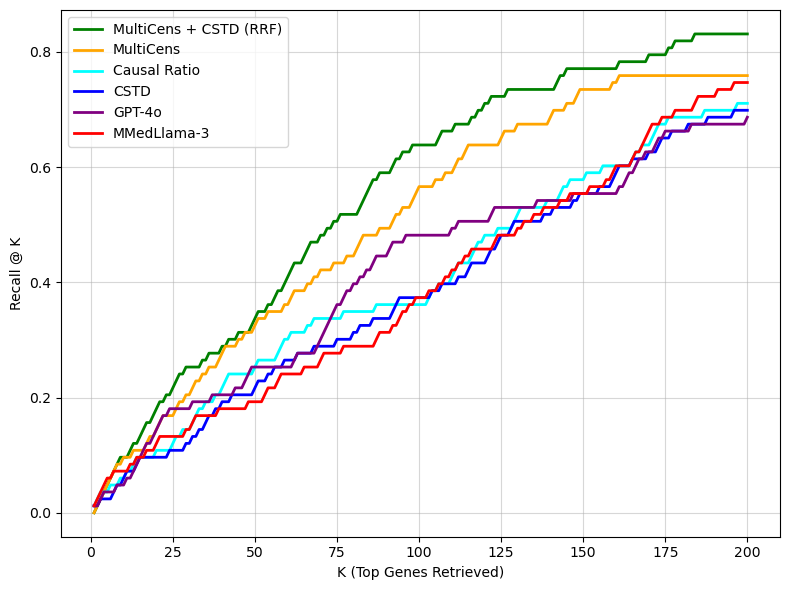

   💾 Saved Recall @ K curve to: /data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/multicens_v17_fixed_results/recall_at_k_curve.png

📊 REGULATORY NETWORK EFFECT SUMMARY (ALL DISEASES)

Gene Distribution:
   bibliometric_only: 232 (67.2%)
   both_layers: 113 (32.8%)

Top 10 Genes by Layer Type:

   BIBLIOMETRIC_ONLY:
      [ ] 163          | Score:   1.0000 | Disease: Myocardial_infarction_susceptibility_to
      [✓] 1636         | Score:   0.8930 | Disease: Myocardial_infarction_susceptibility_to
      [✓] 2627         | Score:   0.8707 | Disease: Tetralogy_of_Fallot
      [✓] 182          | Score:   0.8467 | Disease: Tetralogy_of_Fallot
      [✓] 5290         | Score:   0.8250 | Disease: Gastric_cancer_somatic
      [✓] 23414        | Score:   0.8143 | Disease: Tetralogy_of_Fallot
      [ ] 14011        | Score:   0.7989 | Disease: Leukemia_acute_myeloid_somatic
      [ ] 4297         | Score:   0.7569 | Disease: Leukemia_acute_myeloid_somati

In [17]:
#!/usr/bin/env python3
"""
Matrix-Metapath-Rank v17: Disease-Gene Connectivity
==========================================================
Note: build_graph() already creates Disease → Gene edges.
No bidirectional conversion needed.
"""

import pandas as pd
import numpy as np
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, classification_report
from collections import deque
import os
import sys

# ============================================================================
# CONFIGURATION
# ============================================================================
BASE_PATH = '/data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered'
sys.path.insert(0, BASE_PATH)

try:
    from calculate_pagerank_rrf import load_unified_data, build_graph
except ImportError:
    print("Warning: Could not import load_unified_data. Ensure paths are correct.")

INPUT_FILE = os.path.join(BASE_PATH, 'complete_data_bibliometrics_with_all_diseases_biobert_svm_prediction_updated.tsv')
CRISPR_FILE = os.path.join(BASE_PATH, 'crispr_gene_regulatory_network.tsv')
OUTPUT_DIR = os.path.join(BASE_PATH, 'multicens_v17_fixed_results')
DISEASE_PLOTS_DIR = os.path.join(OUTPUT_DIR, 'disease_plots')

# LLM Files
OPENAI_FILE = os.path.join(BASE_PATH, 'llm_results/All_disease_llm_results_cred.csv')
MEDLLAMA_FILE = '/data/users/nency/llm_results/all_disease_MMed-Llama-3-8B_llm_results_2026-01-25.csv'
OPENAI_NO_CRED_FILE = os.path.join(BASE_PATH, 'llm_results/All_disease_no_cred_llm_results_pure.csv')
MEDLLAMA_NO_CRED_FILE = '/data/users/nency/llm_results/all_disease_MMed-Llama-3-8B_llm_results_2025-12-31.csv'

# Hyperparameters
ALPHA = 0.5           # Damping factor
OMEGA = 0.5             
K_RRF = 60             

# ============================================================================
# UTILS & MATRIX BUILDERS
# ============================================================================

def row_normalize(M):
    """Row-normalize sparse matrix using LIL format for efficiency."""
    M = M.tolil()
    row_sums = np.array(M.sum(axis=1)).flatten()
    sinks = np.where(row_sums == 0)[0]
    for i in sinks:
        M[i, i] = 1.0
        row_sums[i] = 1.0
    M = M.tocsr()
    r_inv = sp.diags(1.0 / row_sums)
    return r_inv.dot(M)

def scale_scores(df, columns):
    """Scale scores to 0-1."""
    for col in columns:
        if col in df.columns:
            min_val = df[col].min()
            max_val = df[col].max()
            if max_val > min_val:
                df[col] = (df[col] - min_val) / (max_val - min_val)
            else:
                df[col] = 0.5
    return df


def plot_disease_curves(disease_df, disease_name, output_dir, methods):
    """
    Generate and save PR curve and Recall@K curve for a single disease.
    
    Args:
        disease_df: DataFrame with results for one disease
        disease_name: Name of the disease
        output_dir: Directory to save plots
        methods: List of (col_name, display_label, color) tuples
    """
    # Filter valid samples
    mask = disease_df['label'].notna() & (disease_df['paper_count'] > 1)
    if mask.sum() < 5:
        return None
    
    y_true = disease_df.loc[mask, 'label'].astype(int).values
    if y_true.sum() == 0:
        return None
    
    # Sanitize disease name for filename
    safe_name = disease_name.replace(' ', '_').replace('/', '_').replace('\\', '_')
    
    # =================
    # PR CURVE
    # =================
    fig, ax = plt.subplots(figsize=(10, 8))
    pos_rate = y_true.mean()
    ax.axhline(y=pos_rate, ls='--', color='gray', alpha=0.5, label=f'Random ({pos_rate:.3f})')
    
    auc_scores = {}
    for col, label, color in methods:
        if col not in disease_df.columns:
            continue
        scores = disease_df.loc[mask, col].fillna(0).values
        if np.all(scores == 0):
            continue
        precision, recall, _ = precision_recall_curve(y_true, scores)
        auc_val = auc(recall, precision)
        auc_scores[label] = auc_val
        ax.plot(recall, precision, lw=2, color=color, label=f'{label} ({auc_val:.3f})')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'Precision-Recall Curve: {disease_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    pr_file = os.path.join(output_dir, f'{safe_name}_pr_curve.png')
    plt.savefig(pr_file, dpi=150, bbox_inches='tight')
    plt.close()
    
    # =================
    # RECALL @ K CURVE
    # =================
    fig, ax = plt.subplots(figsize=(10, 8))
    total_positives = y_true.sum()
    max_k = min(len(y_true), 200)
    x_k = np.arange(1, max_k + 1)
    
    for col, label, color in methods:
        if col not in disease_df.columns:
            continue
        scores = disease_df.loc[mask, col].fillna(0).values
        if np.all(scores == 0):
            continue
        sorted_indices = np.argsort(scores)[::-1]
        sorted_labels = y_true[sorted_indices]
        cum_tp = np.cumsum(sorted_labels)
        recall_at_k = cum_tp[:max_k] / total_positives
        ax.plot(x_k, recall_at_k, lw=2, color=color, label=f'{label}')
    
    ax.set_xlabel('K (Top Genes Retrieved)', fontsize=12)
    ax.set_ylabel('Recall @ K', fontsize=12)
    ax.set_title(f'Recall @ K: {disease_name}', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([1, max_k])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    recall_file = os.path.join(output_dir, f'{safe_name}_recall_at_k.png')
    plt.savefig(recall_file, dpi=150, bbox_inches='tight')
    plt.close()
    
    return auc_scores


def build_supra_adjacency_fixed(G_biblio, crispr_edges, all_genes, seeds, target_id, omega=0.5):
    """
    Builds the Supra-Adjacency Matrix with directed edges.
    
    Note: build_graph() already creates Disease → Gene edges, so we add them
    as directed edges (no bidirectional conversion needed).
    """
    n = len(all_genes)
    gene_to_idx = {str(gene): i for i, gene in enumerate(all_genes)}
    
    print(f"\n   [BUILD] Creating Supra-Adjacency Matrix...")
    print(f"   [BUILD] Total nodes: {n}")
    print(f"   [BUILD] Target Disease: {target_id}")
    
    dis_idx = gene_to_idx.get(str(target_id))
    if dis_idx is not None:
        print(f"   [BUILD] Disease index: {dis_idx}")
    else:
        print(f"   [BUILD] ⚠️ Disease '{target_id}' not in gene_to_idx!")
    
    # --- LAYER 1: BIBLIOMETRIC (DIRECTED) ---
    A_bib = sp.lil_matrix((n, n))
    
    edge_count = 0
    disease_edge_count = 0
    
    # Iterate through ALL edges in NetworkX graph
    for u, v, data in G_biblio.edges(data=True):
        u_str = str(u)
        v_str = str(v)
        
        if u_str in gene_to_idx and v_str in gene_to_idx:
            weight = data.get('weight', 1.0)
            i, j = gene_to_idx[u_str], gene_to_idx[v_str]
            
            # Add edge as directed (build_graph already creates Disease → Gene)
            A_bib[i, j] = weight
            
            edge_count += 1
            
            # Track Disease edges
            if u_str == str(target_id) or v_str == str(target_id):
                disease_edge_count += 1
    
    print(f"   [BUILD] Total edges added: {edge_count}")
    print(f"   [BUILD] Disease-Gene edges: {disease_edge_count}")
    
    # Verify Disease connectivity
    if dis_idx is not None:
        dis_out = A_bib[dis_idx, :].nnz
        dis_in = A_bib[:, dis_idx].nnz
        print(f"   [BUILD] Disease outgoing edges: {dis_out}")
        print(f"   [BUILD] Disease incoming edges: {dis_in}")
    
    A_bib = A_bib.tocsr()
    
    # --- LAYER 2: CRISPR (DIRECTED) ---
    A_reg = sp.lil_matrix((n, n))
    crispr_added = 0
    for s, t, w in crispr_edges:
        s_str, t_str = str(s), str(t)
        if s_str in gene_to_idx and t_str in gene_to_idx:
            i, j = gene_to_idx[s_str], gene_to_idx[t_str]
            A_reg[i, j] = float(w)  # Directed causal edge
            crispr_added += 1
    A_reg = A_reg.tocsr()
    print(f"   [BUILD] CRISPR edges added: {crispr_added}")
    
    # Normalize Layers
    A_bib_norm = row_normalize(A_bib)
    A_reg_norm = row_normalize(A_reg)
    
    # --- RESTRICTED COUPLING (using regulatory network weights) ---
    I_coupling = sp.lil_matrix((n, n))
    seed_indices = [gene_to_idx[str(s)] for s in seeds if str(s) in gene_to_idx]
    
    # Calculate coupling weights from regulatory network
    # Use sum of outgoing edges for each seed node
    if len(seed_indices) > 0:
        reg_weights = []
        for idx in seed_indices:
            # Sum of outgoing regulatory edges for this seed node
            weight_sum = A_reg[idx, :].sum()
            reg_weights.append(float(weight_sum))
        
        # Normalize weights to [0, omega] range if needed, or use directly
        if max(reg_weights) > 0:
            max_weight = max(reg_weights)
            # Scale to omega range, or use raw weights if they're reasonable
            # Option 1: Normalize to omega range
            # reg_weights = [w / max_weight * omega for w in reg_weights]
            # Option 2: Use raw weights (clamped to reasonable range)
            reg_weights = [min(w, omega) if w > omega else w for w in reg_weights]
        else:
            # Fallback to omega if no regulatory edges
            reg_weights = [omega] * len(seed_indices)
        
        for idx, weight in zip(seed_indices, reg_weights):
            I_coupling[idx, idx] = weight
        
    I_coupling = I_coupling.tocsr()
    
    # Build Block Matrix
    A_bib_scaled = A_bib_norm * (1 - omega)
    A_reg_scaled = A_reg_norm * (1 - omega)
    
    M_supra = sp.bmat([
        [A_bib_scaled, I_coupling],
        [I_coupling,   A_reg_scaled]
    ], format='csr')
    
    M_supra = row_normalize(M_supra)
    # print(M_supra,'--------')
    
    # Final verification
    if dis_idx is not None:
        final_out = M_supra[dis_idx, :n].nnz
        # print(f"   [BUILD] ✅ FINAL: Disease has {final_out} outgoing edges in M_supra Layer 1")
    
    return M_supra, gene_to_idx, n


# ============================================================================
# CORE MULTICENS FUNCTIONS
# ============================================================================

def right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_weights_local, p=0.9):
    N = A_tilde_full.shape[0]
    n = int(N / num_layers)
    start_row = target_tissue * n
    end_row = (target_tissue + 1) * n
    
    sub_A = A_tilde_full[start_row:end_row, start_row:end_row]
    
    v_sub = np.zeros(n)
    for idx, weight in target_gene_weights_local.items():
        if idx < n: v_sub[idx] = float(weight)
            
    if v_sub.sum() > 0: v_sub = v_sub / v_sub.sum()
        
    l_sub = v_sub.copy()
    sub_A_t = sub_A.T 
    
    for _ in range(100):
        l_new = p * sub_A_t.dot(l_sub) + (1 - p) * v_sub
        if np.linalg.norm(l_new - l_sub, 1) < 1e-6:
            l_sub = l_new
            break
        l_sub = l_new
    l_full = np.zeros(N)
    l_full[start_row:end_row] = l_sub
    return l_full

def right_target_global_centrality_t(A_tilde_full, num_layers, target_tissue, target_gene_weights_local, p=0.9):
    N = A_tilde_full.shape[0]
    print(N,'-------------hncvmbvcjahkmcvjhgajckbmajhchaskj')
    n = int(N / num_layers)
    
    l = right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_weights_local, p)
    
    A = A_tilde_full.copy()
    A[:n, n:] = 0
    A[n:, :n] = 0
    C = A_tilde_full - A 
    
    v = np.zeros(N)
    start_row = target_tissue * n
    for idx, weight in target_gene_weights_local.items():
        v[start_row + idx] = float(weight)
        
    if v.sum() > 0: v = v / v.sum()
        
    g = v.copy()
    M_t = A_tilde_full.T
    C_t = C.T
    injection = p * C_t.dot(l)
    
    for _ in range(100):
        g_new = p * M_t.dot(g) + injection + (1 - p) * v
        if np.linalg.norm(g_new - g, 1) < 1e-6:
            g = g_new
            break
        g = g_new
    
    new_g = g.copy()
    if target_tissue == 1:
        if new_g[:n].max() > 0: new_g[:n] = g[:n] / g[:n].max()
    elif target_tissue == 0:
        if new_g[n:].max() > 0: new_g[n:] = g[n:] / g[n:].max()
            
    return l, new_g


# ============================================================================
# PATH CONNECTIVITY DIAGNOSTICS
# ============================================================================

def diagnose_path_connectivity(M_supra, g_map, n_genes, target_id, max_hops=4, num_examples=5):
    """
    Diagnose: Can the random walker reach distant genes from Disease?
    """
    print("\n" + "="*60)
    print("🔍 PATH CONNECTIVITY DIAGNOSTIC")
    print("="*60)
    
    idx_to_gene = {v: k for k, v in g_map.items()}
    
    target_str = str(target_id)
    if target_str not in g_map:
        print(f"   ❌ Disease '{target_id}' not in g_map!")
        return None, None
    
    dis_idx = g_map[target_str]
    
    A_biblio = M_supra[:n_genes, :n_genes]
    A_crispr = M_supra[n_genes:, n_genes:]
    
    # --- 1. DIRECT NEIGHBORS ---
    dis_row = A_biblio[dis_idx, :].toarray().flatten()
    direct_neighbors = np.where(dis_row > 0)[0]
    direct_neighbors = [i for i in direct_neighbors if i != dis_idx]
    
    print(f"\n1️⃣  DISEASE DIRECT NEIGHBORS (1-hop)")
    print(f"   Disease '{target_id}' has {len(direct_neighbors)} outgoing edges")
    
    if len(direct_neighbors) == 0:
        print("   ❌ STILL NO OUTGOING EDGES!")
        print("   Random walker CANNOT leave Disease node.")
        return None, None
    else:
        print("   ✅ Disease can reach genes!")
    
    # Show top neighbors by weight
    neighbor_weights = [(i, dis_row[i]) for i in direct_neighbors]
    neighbor_weights.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n   Top neighbors:")
    for idx, weight in neighbor_weights[:5]:
        gene = idx_to_gene.get(idx, "Unknown")
        print(f"   → {gene} (weight: {weight:.4f})")
    
    # --- 2. BFS FOR MULTI-HOP ---
    visited = {dis_idx: 0}
    parent = {dis_idx: None}
    queue = deque([(dis_idx, 0)])
    hop_counts = {0: 1}
    
    while queue:
        current, hops = queue.popleft()
        if hops >= max_hops:
            continue
        
        neighbors_biblio = set(A_biblio[current, :].nonzero()[1])
        neighbors_crispr = set(A_crispr[current, :].nonzero()[1])
        all_neighbors = neighbors_biblio | neighbors_crispr
        
        for neighbor in all_neighbors:
            if neighbor not in visited:
                visited[neighbor] = hops + 1
                parent[neighbor] = current
                queue.append((neighbor, hops + 1))
                hop_counts[hops + 1] = hop_counts.get(hops + 1, 0) + 1
    
    print(f"\n2️⃣  MULTI-HOP REACHABILITY")
    for hop in sorted(hop_counts.keys()):
        if hop == 0:
            print(f"   Hop {hop}: Disease (start)")
        else:
            print(f"   Hop {hop}: {hop_counts[hop]} genes")
    
    total_reachable = len(visited) - 1
    total_genes = n_genes - 1
    coverage = (total_reachable / total_genes * 100) if total_genes > 0 else 0
    
    print(f"\n   📊 COVERAGE: {total_reachable}/{total_genes} ({coverage:.1f}%)")
    
    if coverage >= 90:
        print("   ✅ EXCELLENT! Almost all genes reachable.")
    elif coverage >= 50:
        print("   ℹ️  GOOD. Most genes reachable.")
    else:
        print("   ⚠️  LOW. Many genes unreachable from Disease.")
    
    # --- 3. EXAMPLE PATHS ---
    print(f"\n3️⃣  EXAMPLE PATHS (Disease → A → B → ...)")
    
    # Find multi-hop paths
    multi_hop_genes = [g for g, h in visited.items() if h >= 2 and g != dis_idx]
    
    shown = 0
    for gene_idx in multi_hop_genes[:num_examples]:
        path = []
        current = gene_idx
        while current is not None:
            path.append(current)
            current = parent.get(current)
        path = path[::-1]
        
        path_str = " → ".join([idx_to_gene.get(p, str(p)) for p in path])
        print(f"   [{visited[gene_idx]}-hop] {path_str}")
        shown += 1
    
    if shown == 0:
        # Show 1-hop paths instead
        one_hop = [g for g, h in visited.items() if h == 1][:3]
        for gene_idx in one_hop:
            gene = idx_to_gene.get(gene_idx, str(gene_idx))
            print(f"   [1-hop] {target_id} → {gene}")
    
    # --- 4. GENE-GENE CONNECTIVITY ---
    print(f"\n4️⃣  GENE-GENE EDGES (for multi-hop paths)")
    
    gene_gene_biblio = 0
    gene_gene_crispr = 0
    
    for i in range(n_genes):
        if i == dis_idx:
            continue
        for j in A_biblio[i, :].nonzero()[1]:
            if j != dis_idx and j > i:
                gene_gene_biblio += 1
        for j in A_crispr[i, :].nonzero()[1]:
            if j != dis_idx and j > i:
                gene_gene_crispr += 1
    
    print(f"   Bibliometric Gene-Gene edges: {gene_gene_biblio}")
    print(f"   CRISPR Gene-Gene edges: {gene_gene_crispr}")
    
    if gene_gene_biblio + gene_gene_crispr == 0:
        print("   ⚠️  NO Gene-Gene edges! Only Disease↔Gene connections exist.")
        print("   This is a STAR topology - paths limited to 1 hop.")
    else:
        print("   ✅ Gene-Gene edges exist for multi-hop propagation.")
    
    print("="*60)
    
    return visited, parent


# ============================================================================
# FUSION & HELPERS
# ============================================================================

def calculate_rrf(matrix_scores, vq_map, k=60):
    genes = list(matrix_scores.keys())
    if not genes: return {}
    results = []
    for gene in genes:
        results.append({'gene': gene, 'mat': matrix_scores.get(gene, 0), 'vq': vq_map.get(gene, 0)})
    df = pd.DataFrame(results)
    
    df['r_mat'] = df['mat'].rank(ascending=False)
    df['r_vq'] = df['vq'].rank(ascending=False)
    
    df['score'] = (1 / (k + df['r_mat'])) + (1 / (k + df['r_vq']))
    return dict(zip(df['gene'], df['score']))


def load_llm_scores(filepath, df_full):
    if not os.path.exists(filepath): return {}
    llm_df = pd.read_csv(filepath)
    if 'id1' in llm_df.columns: llm_df['id1'] = llm_df['id1'].astype(str).str.replace(r'\.0$', '', regex=True)
    if 'id2' in llm_df.columns: llm_df['id2'] = llm_df['id2'].astype(str).str.replace(r'\.0$', '', regex=True)
    
    dis_map = {}
    if 'disease' in df_full.columns:
        temp = df_full[['id2', 'disease']].drop_duplicates()
        dis_map = dict(zip(temp['id2'].astype(str).str.replace(r'\.0$', '', regex=True), temp['disease']))
    
    score_map = {}
    for _, row in llm_df.iterrows():
        d_key = str(row['id2'])
        d_name = dis_map.get(d_key, d_key)
        val = float(row.get('score', row.get('probability', row.get('llm_score', 0))))
        relationship_status = row.get('relationship', row.get('llm_relationship', row.get('label', row.get('prediction', ''))))
        print(relationship_status)
        if isinstance(relationship_status, str):
            status_lower = relationship_status.lower()
            if ('negative' in status_lower or 'not causal' in status_lower or 
                'non-causal' in status_lower or 'no association' in status_lower):
                if val > 0.5: val = 1.0 - val
            elif('causal' in status_lower):
                print(val)
                if val < 0.5: val = 1.0 - val
        if pd.notna(val): score_map[(d_name, str(row['id1']))] = val
            
    return score_map

def analyze_seed_regulatory_connections(seeds, crispr_edges, label_map):
    """
    Analyze how many seed genes have connections in the regulatory network.
    """
    print("\n" + "="*60)
    print("🌱 SEED GENES REGULATORY CONNECTION ANALYSIS")
    print("="*60)
    
    # Build regulatory network adjacency
    reg_genes = set()
    reg_edges = {}  # gene -> list of (target, weight)
    reg_in_edges = {}  # gene -> list of (source, weight)
    
    for s, t, w in crispr_edges:
        s_str, t_str = str(s), str(t)
        reg_genes.add(s_str)
        reg_genes.add(t_str)
        
        if s_str not in reg_edges:
            reg_edges[s_str] = []
        reg_edges[s_str].append((t_str, w))
        
        if t_str not in reg_in_edges:
            reg_in_edges[t_str] = []
        reg_in_edges[t_str].append((s_str, w))
    
    seeds_set = set([str(s) for s in seeds])
    
    # Analyze seed connectivity
    seeds_in_reg = seeds_set & reg_genes
    seeds_not_in_reg = seeds_set - reg_genes
    
    print(f"\n1️⃣  SEED GENES OVERVIEW")
    print(f"   Total seed genes: {len(seeds_set)}")
    print(f"   Seeds IN regulatory network: {len(seeds_in_reg)} ({len(seeds_in_reg)/len(seeds_set)*100:.1f}%)")
    print(f"   Seeds NOT in regulatory network: {len(seeds_not_in_reg)} ({len(seeds_not_in_reg)/len(seeds_set)*100:.1f}%)")
    
    # Detailed connectivity for seeds in regulatory network
    print(f"\n2️⃣  SEED CONNECTIVITY DETAILS")
    seed_connections = []
    for seed in seeds_in_reg:
        out_edges = reg_edges.get(seed, [])
        in_edges = reg_in_edges.get(seed, [])
        
        # Count connections to other seeds
        out_to_seeds = [t for t, w in out_edges if t in seeds_set]
        in_from_seeds = [s for s, w in in_edges if s in seeds_set]
        
        # Count connections to non-seeds
        out_to_non_seeds = [t for t, w in out_edges if t not in seeds_set]
        in_from_non_seeds = [s for s, w in in_edges if s not in seeds_set]
        
        label = label_map.get(seed, 0)
        seed_connections.append({
            'seed': seed,
            'label': label,
            'out_total': len(out_edges),
            'in_total': len(in_edges),
            'out_to_seeds': len(out_to_seeds),
            'in_from_seeds': len(in_from_seeds),
            'out_to_non_seeds': len(out_to_non_seeds),
            'in_from_non_seeds': len(in_from_non_seeds),
            'total_connections': len(out_edges) + len(in_edges)
        })
    
    # Sort by total connections
    seed_connections.sort(key=lambda x: x['total_connections'], reverse=True)
    
    # print(f"\n   Top 10 most connected seed genes:")
    # print(f"   {'Gene':<12} | {'Label':^5} | {'Out':^4} | {'In':^4} | {'→Seeds':^6} | {'←Seeds':^6} | {'Total':^5}")
    # print(f"   {'-'*12}-+-{'-'*5}-+-{'-'*4}-+-{'-'*4}-+-{'-'*6}-+-{'-'*6}-+-{'-'*5}")
    
    for conn in seed_connections[:10]:
        marker = "✓" if conn['label'] == 1 else " "
        # print(f"   {conn['seed']:<12} |   {marker}   | {conn['out_total']:>4} | {conn['in_total']:>4} | {conn['out_to_seeds']:>6} | {conn['in_from_seeds']:>6} | {conn['total_connections']:>5}")
    
    # Statistics
    if seed_connections:
        total_out = sum(c['out_total'] for c in seed_connections)
        total_in = sum(c['in_total'] for c in seed_connections)
        avg_connections = sum(c['total_connections'] for c in seed_connections) / len(seed_connections)
        
        print(f"\n3️⃣  CONNECTIVITY STATISTICS")
        print(f"   Total outgoing edges from seeds: {total_out}")
        print(f"   Total incoming edges to seeds: {total_in}")
        print(f"   Average connections per seed: {avg_connections:.1f}")
        
        # Seed-to-seed connections
        seed_to_seed = sum(c['out_to_seeds'] for c in seed_connections)
        print(f"   Seed→Seed connections: {seed_to_seed}")
        
        # Seeds with no connections
        isolated_seeds = [c for c in seed_connections if c['total_connections'] == 0]
        print(f"   Isolated seeds (0 connections): {len(isolated_seeds)}")
    
    # Seeds NOT in regulatory network
    if seeds_not_in_reg:
        # print(f"\n4️⃣  SEEDS WITHOUT REGULATORY CONNECTIONS")
        # print(f"   These {len(seeds_not_in_reg)} seed genes have NO regulatory network edges:")
        seeds_not_in_reg_list = list(seeds_not_in_reg)[:20]
        for i, seed in enumerate(seeds_not_in_reg_list, 1):
            label = label_map.get(seed, 0)
            marker = "✓" if label == 1 else " "
            # print(f"      {i:>2}. [{marker}] {seed}")
        if len(seeds_not_in_reg) > 20:
            print(f"      ... and {len(seeds_not_in_reg) - 20} more")
    
    # True positive analysis
    print(f"\n5️⃣  TRUE POSITIVE RATE BY REGULATORY CONNECTION")
    seeds_in_reg_tp = sum(1 for s in seeds_in_reg if label_map.get(s, 0) == 1)
    seeds_not_in_reg_tp = sum(1 for s in seeds_not_in_reg if label_map.get(s, 0) == 1)
    
    # if len(seeds_in_reg) > 0:
    #     print(f"   Seeds IN regulatory network: {seeds_in_reg_tp}/{len(seeds_in_reg)} TPs ({seeds_in_reg_tp/len(seeds_in_reg)*100:.1f}%)")
    # if len(seeds_not_in_reg) > 0:
    #     print(f"   Seeds NOT in regulatory network: {seeds_not_in_reg_tp}/{len(seeds_not_in_reg)} TPs ({seeds_not_in_reg_tp/len(seeds_not_in_reg)*100:.1f}%)")
    
    # print("="*60)
    
    return {
        'seeds_in_reg': list(seeds_in_reg),
        'seeds_not_in_reg': list(seeds_not_in_reg),
        'seed_connections': seed_connections
    }


def analyze_regulatory_network_genes(crispr_edges, df_full, sym_map):
    """
    Comprehensive analysis of what genes are available in the regulatory network.
    """
    print("\n" + "="*70)
    print("🧬 REGULATORY NETWORK GENE ANALYSIS")
    print("="*70)
    
    if not crispr_edges:
        print("   ⚠️ No CRISPR edges loaded!")
        return {}
    
    # 1. Basic statistics
    source_genes = set()
    target_genes = set()
    all_reg_genes = set()
    edge_weights = []
    
    for s, t, w in crispr_edges:
        source_genes.add(s)
        target_genes.add(t)
        all_reg_genes.add(s)
        all_reg_genes.add(t)
        edge_weights.append(w)
    
    print(f"\n1️⃣  BASIC STATISTICS")
    print(f"   Total edges in regulatory network: {len(crispr_edges)}")
    print(f"   Unique source genes (regulators): {len(source_genes)}")
    print(f"   Unique target genes (regulated): {len(target_genes)}")
    print(f"   Total unique genes: {len(all_reg_genes)}")
    print(f"   Genes that are BOTH source & target: {len(source_genes & target_genes)}")
    print(f"   Genes that are ONLY source: {len(source_genes - target_genes)}")
    print(f"   Genes that are ONLY target: {len(target_genes - source_genes)}")
    
    # 2. Edge weight statistics
    # print(f"\n2️⃣  EDGE WEIGHT STATISTICS")
    # print(f"   Min weight: {min(edge_weights):.4f}")
    # print(f"   Max weight: {max(edge_weights):.4f}")
    # print(f"   Mean weight: {np.mean(edge_weights):.4f}")
    # print(f"   Median weight: {np.median(edge_weights):.4f}")
    
    # 3. Connectivity analysis
    out_degree = {}  # gene -> number of outgoing edges
    in_degree = {}   # gene -> number of incoming edges
    
    for s, t, w in crispr_edges:
        out_degree[s] = out_degree.get(s, 0) + 1
        in_degree[t] = in_degree.get(t, 0) + 1
    
    # print(f"\n3️⃣  CONNECTIVITY ANALYSIS")
    # print(f"   {'Metric':<35} | {'Out-degree':>12} | {'In-degree':>12}")
    # print(f"   {'-'*35}-+-{'-'*12}-+-{'-'*12}")
    # print(f"   {'Max degree':<35} | {max(out_degree.values()):>12} | {max(in_degree.values()):>12}")
    # print(f"   {'Mean degree':<35} | {np.mean(list(out_degree.values())):>12.2f} | {np.mean(list(in_degree.values())):>12.2f}")
    # print(f"   {'Median degree':<35} | {np.median(list(out_degree.values())):>12.1f} | {np.median(list(in_degree.values())):>12.1f}")
    
    # 4. Top hub genes (highest out-degree = regulators)
    # print(f"\n4️⃣  TOP 10 HUB GENES (Highest Out-degree - Major Regulators)")
    top_hubs = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # Reverse symbol lookup
    id_to_sym = {v: k for k, v in sym_map.items()}
    
    # print(f"   {'Gene ID':<12} | {'Symbol':<15} | {'Out-degree':>10} | {'In-degree':>10}")
    # print(f"   {'-'*12}-+-{'-'*15}-+-{'-'*10}-+-{'-'*10}")
    for gene_id, out_deg in top_hubs:
        symbol = id_to_sym.get(gene_id, "?")
        in_deg = in_degree.get(gene_id, 0)
        # print(f"   {gene_id:<12} | {symbol:<15} | {out_deg:>10} | {in_deg:>10}")
    
    # 5. Top regulated genes (highest in-degree)
    # print(f"\n5️⃣  TOP 10 MOST REGULATED GENES (Highest In-degree)")
    top_regulated = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # print(f"   {'Gene ID':<12} | {'Symbol':<15} | {'In-degree':>10} | {'Out-degree':>10}")
    # print(f"   {'-'*12}-+-{'-'*15}-+-{'-'*10}-+-{'-'*10}")
    for gene_id, in_deg in top_regulated:
        symbol = id_to_sym.get(gene_id, "?")
        out_deg = out_degree.get(gene_id, 0)
        # print(f"   {gene_id:<12} | {symbol:<15} | {in_deg:>10} | {out_deg:>10}")
    
    # 6. Coverage analysis with bibliometric data
    all_biblio_genes = set(df_full['id1'].astype(str).unique())
    reg_in_biblio = all_reg_genes & all_biblio_genes
    reg_not_in_biblio = all_reg_genes - all_biblio_genes
    biblio_not_in_reg = all_biblio_genes - all_reg_genes
    
    # print(f"\n6️⃣  COVERAGE WITH BIBLIOMETRIC DATA")
    # print(f"   Total bibliometric genes (all diseases): {len(all_biblio_genes)}")
    # print(f"   Regulatory genes IN bibliometric: {len(reg_in_biblio)} ({len(reg_in_biblio)/len(all_reg_genes)*100:.1f}% of reg)")
    # print(f"   Regulatory genes NOT in bibliometric: {len(reg_not_in_biblio)} ({len(reg_not_in_biblio)/len(all_reg_genes)*100:.1f}% of reg)")
    # print(f"   Bibliometric genes NOT in regulatory: {len(biblio_not_in_reg)} ({len(biblio_not_in_reg)/len(all_biblio_genes)*100:.1f}% of biblio)")
    
    # 7. Seed analysis - genes marked as causal (pred_label=1)
    print(f"\n7️⃣  SEED GENE ANALYSIS (pred_label=1)")
    
    # Get seeds from bibliometric data (genes with pred_label=1)
    if 'pred_label' in df_full.columns:
        seed_df = df_full[df_full['pred_label'] == 1]
        all_seeds = set(seed_df['id1'].astype(str).unique())
        
        # How many of 259 regulatory genes are seeds?
        reg_seeds = all_reg_genes & all_seeds
        reg_non_seeds = all_reg_genes - all_seeds
        
        # print(f"   Total unique seeds in bibliometric: {len(all_seeds)}")
        # print(f"   Regulatory genes that are SEEDS: {len(reg_seeds)} ({len(reg_seeds)/len(all_reg_genes)*100:.1f}% of 259 reg genes)")
        # print(f"   Regulatory genes that are NON-SEEDS: {len(reg_non_seeds)} ({len(reg_non_seeds)/len(all_reg_genes)*100:.1f}% of 259 reg genes)")
        # print(f"   Seeds that are in regulatory: {len(reg_seeds)} ({len(reg_seeds)/len(all_seeds)*100:.1f}% of all seeds)")
        
        # Breakdown by source/target
        seed_sources = source_genes & all_seeds
        seed_targets = target_genes & all_seeds
        # print(f"\n   Breakdown of seed genes in regulatory:")
        # print(f"   - Seeds that are SOURCE genes (regulators): {len(seed_sources)}")
        # print(f"   - Seeds that are TARGET genes (regulated): {len(seed_targets)}")
        # print(f"   - Seeds that are BOTH source & target: {len(seed_sources & seed_targets)}")
    else:
        print("   ⚠️ No pred_label column found in data")
        all_seeds = set()
        reg_seeds = set()
    
    # 8. Label analysis for regulatory genes (True Positives = label=1)
    label_map_all = dict(zip(df_full['id1'].astype(str), df_full['label'].fillna(0)))
    
    reg_tp = sum(1 for g in reg_in_biblio if label_map_all.get(g, 0) == 1)
    biblio_tp = sum(1 for g in all_biblio_genes if label_map_all.get(g, 0) == 1)
    
    # print(f"\n8️⃣  TRUE POSITIVE ANALYSIS (label=1, OMIM validated)")
    # print(f"   Total TPs in bibliometric data: {biblio_tp}")
    # print(f"   TPs that are also in regulatory: {reg_tp} ({reg_tp/biblio_tp*100:.1f}% of TPs)" if biblio_tp > 0 else "   No TPs found")
    
    # 9. Degree distribution
    print(f"\n9️⃣  DEGREE DISTRIBUTION")
    out_deg_values = list(out_degree.values())
    in_deg_values = list(in_degree.values())
    
    out_percentiles = np.percentile(out_deg_values, [25, 50, 75, 90, 95, 99])
    in_percentiles = np.percentile(in_deg_values, [25, 50, 75, 90, 95, 99])
    
    # print(f"   {'Percentile':<15} | {'Out-degree':>12} | {'In-degree':>12}")
    # print(f"   {'-'*15}-+-{'-'*12}-+-{'-'*12}")
    # for i, p in enumerate([25, 50, 75, 90, 95, 99]):
        # print(f"   {p}th percentile  | {out_percentiles[i]:>12.1f} | {in_percentiles[i]:>12.1f}")
    
    # print("="*70)
    
    return {
        'total_edges': len(crispr_edges),
        'unique_genes': len(all_reg_genes),
        'source_genes': len(source_genes),
        'target_genes': len(target_genes),
        'reg_in_biblio': len(reg_in_biblio),
        'reg_not_in_biblio': len(reg_not_in_biblio),
        'top_hubs': top_hubs,
        'out_degree': out_degree,
        'in_degree': in_degree,
        'reg_seeds': list(reg_seeds) if 'reg_seeds' in dir() else [],
        'all_seeds': list(all_seeds) if 'all_seeds' in dir() else []
    }


def analyze_regulatory_effect_on_seed_rankings(all_results_df, crispr_edges, df_full):
    """
    Analyze the effect of regulatory network on the 91 seed genes that have regulatory connections.
    Compare rankings of seeds WITH regulatory connections vs seeds WITHOUT.
    """
    print("\n" + "="*70)
    print("📈 REGULATORY NETWORK EFFECT ON SEED GENE RANKINGS")
    print("="*70)
    
    if all_results_df is None or len(all_results_df) == 0:
        print("   ⚠️ No results data available")
        return
    
    # Get all regulatory genes
    reg_genes = set()
    out_degree = {}
    in_degree = {}
    for s, t, w in crispr_edges:
        reg_genes.add(str(s))
        reg_genes.add(str(t))
        out_degree[str(s)] = out_degree.get(str(s), 0) + 1
        in_degree[str(t)] = in_degree.get(str(t), 0) + 1
    
    # Get seeds from bibliometric data
    if 'pred_label' in df_full.columns:
        seed_df = df_full[df_full['pred_label'] == 1]
        all_seeds = set(seed_df['id1'].astype(str).unique())
    else:
        print("   ⚠️ No pred_label column")
        return
    
    # Seeds with and without regulatory connections
    seeds_with_reg = all_seeds & reg_genes
    seeds_without_reg = all_seeds - reg_genes
    
    print(f"\n1️⃣  SEED GENE COUNTS")
    print(f"   Total seeds: {len(all_seeds)}")
    print(f"   Seeds WITH regulatory connections: {len(seeds_with_reg)}")
    print(f"   Seeds WITHOUT regulatory connections: {len(seeds_without_reg)}")
    
    # Analyze rankings from results
    results_df = all_results_df.copy()
    results_df['gene_id'] = results_df['gene_id'].astype(str)
    
    # Add seed and regulatory flags
    results_df['is_seed'] = results_df['gene_id'].isin(all_seeds)
    results_df['has_reg'] = results_df['gene_id'].isin(reg_genes)
    results_df['seed_with_reg'] = results_df['gene_id'].isin(seeds_with_reg)
    results_df['seed_without_reg'] = results_df['gene_id'].isin(seeds_without_reg)
    
    # Get seed results only
    seed_results = results_df[results_df['is_seed'] == True].copy()
    
    # print(f"\n2️⃣  RANKING COMPARISON (Seeds with vs without regulatory)")
    
    # Overall statistics
    with_reg = seed_results[seed_results['seed_with_reg'] == True]
    without_reg = seed_results[seed_results['seed_without_reg'] == True]
    
    # print(f"\n   {'Metric':<30} | {'With Reg':>12} | {'Without Reg':>12}")
    # print(f"   {'-'*30}-+-{'-'*12}-+-{'-'*12}")
    
    if len(with_reg) > 0 and len(without_reg) > 0:
        # Average rank
        avg_rank_with = with_reg['rank'].mean()
        avg_rank_without = without_reg['rank'].mean()
        # print(f"   {'Average Rank':<30} | {avg_rank_with:>12.1f} | {avg_rank_without:>12.1f}")
        
        # Median rank
        med_rank_with = with_reg['rank'].median()
        med_rank_without = without_reg['rank'].median()
        # print(f"   {'Median Rank':<30} | {med_rank_with:>12.1f} | {med_rank_without:>12.1f}")
        
        # Average score
        if 'multicens_score' in with_reg.columns:
            avg_score_with = with_reg['multicens_score'].mean()
            avg_score_without = without_reg['multicens_score'].mean()
            # print(f"   {'Average MultiCens Score':<30} | {avg_score_with:>12.6f} | {avg_score_without:>12.6f}")
        
        # Top 10 presence
        top10_with = len(with_reg[with_reg['rank'] <= 10])
        top10_without = len(without_reg[without_reg['rank'] <= 10])
        # print(f"   {'Count in Top 10':<30} | {top10_with:>12} | {top10_without:>12}")
        
        # Top 20 presence
        top20_with = len(with_reg[with_reg['rank'] <= 20])
        top20_without = len(without_reg[without_reg['rank'] <= 20])
        # print(f"   {'Count in Top 20':<30} | {top20_with:>12} | {top20_without:>12}")
        
        # Top 50 presence
        top50_with = len(with_reg[with_reg['rank'] <= 50])
        top50_without = len(without_reg[without_reg['rank'] <= 50])
        # print(f"   {'Count in Top 50':<30} | {top50_with:>12} | {top50_without:>12}")
    
    # 3. True Positive analysis
    print(f"\n3️⃣  TRUE POSITIVE RATE")
    tp_with_reg = len(with_reg[with_reg['label'] == 1]) if 'label' in with_reg.columns else 0
    tp_without_reg = len(without_reg[without_reg['label'] == 1]) if 'label' in without_reg.columns else 0
    
    print(f"   Seeds WITH reg that are TPs: {tp_with_reg}/{len(with_reg)} ({tp_with_reg/len(with_reg)*100:.1f}%)" if len(with_reg) > 0 else "   N/A")
    print(f"   Seeds WITHOUT reg that are TPs: {tp_without_reg}/{len(without_reg)} ({tp_without_reg/len(without_reg)*100:.1f}%)" if len(without_reg) > 0 else "   N/A")
    
    # 4. Top seeds with regulatory connections
    # print(f"\n4️⃣  TOP 15 SEEDS WITH REGULATORY CONNECTIONS (by rank)")
    top_seeds_with_reg = with_reg.nsmallest(15, 'rank')
    
    # print(f"   {'Rank':>5} | {'Gene ID':<10} | {'Score':>12} | {'Label':>5} | {'Out-deg':>8} | {'In-deg':>8}")
    # print(f"   {'-'*5}-+-{'-'*10}-+-{'-'*12}-+-{'-'*5}-+-{'-'*8}-+-{'-'*8}")
    
    for _, row in top_seeds_with_reg.iterrows():
        gene = str(row['gene_id'])
        rank = row['rank']
        score = row.get('multicens_score', 0)
        label = row.get('label', 0)
        out_d = out_degree.get(gene, 0)
        in_d = in_degree.get(gene, 0)
        marker = "✓" if label == 1 else " "
        print(f"   {int(rank):>5} | {gene:<10} | {score:>12.6f} | {marker:>5} | {out_d:>8} | {in_d:>8}")
    
    # 5. Correlation analysis
    print(f"\n5️⃣  CORRELATION: Regulatory Connectivity vs Ranking")
    
    # Add connectivity to with_reg dataframe
    with_reg_analysis = with_reg.copy()
    with_reg_analysis['out_degree'] = with_reg_analysis['gene_id'].apply(lambda x: out_degree.get(str(x), 0))
    with_reg_analysis['in_degree'] = with_reg_analysis['gene_id'].apply(lambda x: in_degree.get(str(x), 0))
    with_reg_analysis['total_degree'] = with_reg_analysis['out_degree'] + with_reg_analysis['in_degree']
    
    if len(with_reg_analysis) > 5:
        # Correlation between degree and rank
        corr_out_rank = with_reg_analysis['out_degree'].corr(with_reg_analysis['rank'])
        corr_in_rank = with_reg_analysis['in_degree'].corr(with_reg_analysis['rank'])
        corr_total_rank = with_reg_analysis['total_degree'].corr(with_reg_analysis['rank'])
        
        # print(f"   Out-degree vs Rank correlation: {corr_out_rank:.3f} {'(higher out-degree → better rank)' if corr_out_rank < 0 else '(higher out-degree → worse rank)'}")
        # print(f"   In-degree vs Rank correlation: {corr_in_rank:.3f} {'(higher in-degree → better rank)' if corr_in_rank < 0 else '(higher in-degree → worse rank)'}")
        # print(f"   Total-degree vs Rank correlation: {corr_total_rank:.3f}")
    
    # 6. TRUE POSITIVE vs FALSE POSITIVE SEED ANALYSIS
    print(f"\n6️⃣  TRUE POSITIVE vs FALSE POSITIVE SEED BREAKDOWN")
    
    # Get unique seeds and their labels
    label_map = dict(zip(df_full['id1'].astype(str), df_full['label'].fillna(0)))
    
    # Categorize seeds
    tp_seeds = set(s for s in all_seeds if label_map.get(s, 0) == 1)  # True Positives
    fp_seeds = set(s for s in all_seeds if label_map.get(s, 0) == 0)  # False Positives
    
    tp_with_reg_set = tp_seeds & reg_genes
    tp_without_reg_set = tp_seeds - reg_genes
    fp_with_reg_set = fp_seeds & reg_genes
    fp_without_reg_set = fp_seeds - reg_genes
    
    # print(f"\n   SEED GENE BREAKDOWN:")
    # print(f"   {'Category':<35} | {'Count':>8} | {'% of Seeds':>10}")
    # print(f"   {'-'*35}-+-{'-'*8}-+-{'-'*10}")
    # print(f"   {'Total Seed Genes':<35} | {len(all_seeds):>8} | {'100.0%':>10}")
    # print(f"   {'├─ TRUE POSITIVES (label=1)':<35} | {len(tp_seeds):>8} | {len(tp_seeds)/len(all_seeds)*100:>9.1f}%")
    # print(f"   {'│  ├─ WITH regulatory connections':<35} | {len(tp_with_reg_set):>8} | {len(tp_with_reg_set)/len(all_seeds)*100:>9.1f}%")
    # print(f"   {'│  └─ WITHOUT regulatory connections':<35} | {len(tp_without_reg_set):>8} | {len(tp_without_reg_set)/len(all_seeds)*100:>9.1f}%")
    # print(f"   {'└─ FALSE POSITIVES (label=0)':<35} | {len(fp_seeds):>8} | {len(fp_seeds)/len(all_seeds)*100:>9.1f}%")
    # print(f"   {'   ├─ WITH regulatory connections':<35} | {len(fp_with_reg_set):>8} | {len(fp_with_reg_set)/len(all_seeds)*100:>9.1f}%")
    # print(f"   {'   └─ WITHOUT regulatory connections':<35} | {len(fp_without_reg_set):>8} | {len(fp_without_reg_set)/len(all_seeds)*100:>9.1f}%")
    
    # Ranking analysis for each category
    # print(f"\n   RANKING EFFECT BY CATEGORY:")
    
    # Filter results for each category
    tp_with_reg_results = seed_results[seed_results['gene_id'].isin(tp_with_reg_set)]
    tp_without_reg_results = seed_results[seed_results['gene_id'].isin(tp_without_reg_set)]
    fp_with_reg_results = seed_results[seed_results['gene_id'].isin(fp_with_reg_set)]
    fp_without_reg_results = seed_results[seed_results['gene_id'].isin(fp_without_reg_set)]
    
    # print(f"\n   {'Category':<40} | {'Avg Rank':>10} | {'Med Rank':>10} | {'Top 10':>8} | {'Top 20':>8}")
    # print(f"   {'-'*40}-+-{'-'*10}-+-{'-'*10}-+-{'-'*8}-+-{'-'*8}")
    
    categories = [
        ('TP + WITH regulatory', tp_with_reg_results),
        ('TP + WITHOUT regulatory', tp_without_reg_results),
        ('FP + WITH regulatory', fp_with_reg_results),
        ('FP + WITHOUT regulatory', fp_without_reg_results)
    ]
    
    for cat_name, cat_df in categories:
        if len(cat_df) > 0:
            avg_r = cat_df['rank'].mean()
            med_r = cat_df['rank'].median()
            top10 = len(cat_df[cat_df['rank'] <= 10])
            top20 = len(cat_df[cat_df['rank'] <= 20])
            # print(f"   {cat_name:<40} | {avg_r:>10.1f} | {med_r:>10.1f} | {top10:>8} | {top20:>8}")
        # else:
            # print(f"   {cat_name:<40} | {'N/A':>10} | {'N/A':>10} | {'N/A':>8} | {'N/A':>8}")
    
    # Key insight: Effect on TPs vs FPs
    print(f"\n   REGULATORY EFFECT COMPARISON:")
    
    if len(tp_with_reg_results) > 0 and len(tp_without_reg_results) > 0:
        tp_rank_diff = tp_without_reg_results['rank'].mean() - tp_with_reg_results['rank'].mean()
        # print(f"   For TRUE POSITIVES: Regulatory gives {tp_rank_diff:.1f} positions {'BETTER' if tp_rank_diff > 0 else 'WORSE'} ranking")
    
    if len(fp_with_reg_results) > 0 and len(fp_without_reg_results) > 0:
        fp_rank_diff = fp_without_reg_results['rank'].mean() - fp_with_reg_results['rank'].mean()
        # print(f"   For FALSE POSITIVES: Regulatory gives {fp_rank_diff:.1f} positions {'BETTER' if fp_rank_diff > 0 else 'WORSE'} ranking")
    
    # Precision impact
    print(f"\n   PRECISION IMPACT (Does regulatory help identify TPs?):")
    
    if len(tp_with_reg_set) > 0 and len(fp_with_reg_set) > 0:
        precision_with_reg = len(tp_with_reg_set) / (len(tp_with_reg_set) + len(fp_with_reg_set))
        # print(f"   Seeds WITH regulatory: {len(tp_with_reg_set)} TPs / {len(tp_with_reg_set) + len(fp_with_reg_set)} total = {precision_with_reg*100:.1f}% precision")
    
    if len(tp_without_reg_set) > 0 and len(fp_without_reg_set) > 0:
        precision_without_reg = len(tp_without_reg_set) / (len(tp_without_reg_set) + len(fp_without_reg_set))
        # print(f"   Seeds WITHOUT regulatory: {len(tp_without_reg_set)} TPs / {len(tp_without_reg_set) + len(fp_without_reg_set)} total = {precision_without_reg*100:.1f}% precision")
    
    # 7. MultiCens vs CSTD Ranking Comparison
    # print(f"\n7️⃣  MULTICENS vs CSTD RANKING COMPARISON")
    
    if 'VQ_star' in all_results_df.columns:
        # Add CSTD rank per disease
        compare_df = all_results_df.copy()
        compare_df['cstd_rank'] = compare_df.groupby('disease')['VQ_star'].rank(ascending=False, method='min')
        compare_df['multicens_rank'] = compare_df['rank']
        
        # Rank difference: positive = MultiCens ranked better
        compare_df['rank_improvement'] = compare_df['cstd_rank'] - compare_df['multicens_rank']
        
        # Filter to seeds only
        seed_compare = compare_df[compare_df['gene_id'].isin(all_seeds)].copy()
        seed_compare['has_reg'] = seed_compare['gene_id'].isin(reg_genes)
        seed_compare['is_tp'] = seed_compare['label'] == 1
        
        # Overall comparison
        better_multicens = len(seed_compare[seed_compare['rank_improvement'] > 0])
        worse_multicens = len(seed_compare[seed_compare['rank_improvement'] < 0])
        same_rank = len(seed_compare[seed_compare['rank_improvement'] == 0])
        
        # print(f"\n   SEED GENES RANKING CHANGES (MultiCens vs CSTD):")
        # print(f"   {'Category':<40} | {'Count':>8} | {'%':>8}")
        # print(f"   {'-'*40}-+-{'-'*8}-+-{'-'*8}")
        # print(f"   {'Seeds ranked BETTER by MultiCens':<40} | {better_multicens:>8} | {better_multicens/len(seed_compare)*100:>7.1f}%")
        # print(f"   {'Seeds ranked WORSE by MultiCens':<40} | {worse_multicens:>8} | {worse_multicens/len(seed_compare)*100:>7.1f}%")
        # print(f"   {'Seeds with SAME rank':<40} | {same_rank:>8} | {same_rank/len(seed_compare)*100:>7.1f}%")
        # print(f"   {'Average rank improvement':<40} | {seed_compare['rank_improvement'].mean():>8.1f} | positions")
        
        # By regulatory status
        # print(f"\n   BY REGULATORY STATUS:")
        for has_reg, label in [(True, 'WITH regulatory'), (False, 'WITHOUT regulatory')]:
            subset = seed_compare[seed_compare['has_reg'] == has_reg]
            if len(subset) > 0:
                better = len(subset[subset['rank_improvement'] > 0])
                worse = len(subset[subset['rank_improvement'] < 0])
                avg_imp = subset['rank_improvement'].mean()
                # print(f"   {label}: {better} better, {worse} worse, avg improvement: {avg_imp:.1f} positions")
        
        # By TP/FP status
        # print(f"\n   BY TRUE POSITIVE / FALSE POSITIVE:")
        for is_tp, label in [(True, 'TRUE POSITIVES'), (False, 'FALSE POSITIVES')]:
            subset = seed_compare[seed_compare['is_tp'] == is_tp]
            if len(subset) > 0:
                better = len(subset[subset['rank_improvement'] > 0])
                worse = len(subset[subset['rank_improvement'] < 0])
                avg_imp = subset['rank_improvement'].mean()
                # print(f"   {label}: {better} better, {worse} worse, avg improvement: {avg_imp:.1f} positions")
        
        # Combined analysis: TP/FP x Regulatory
        # print(f"\n   DETAILED BREAKDOWN (TP/FP × Regulatory):")
        # print(f"   {'Category':<35} | {'Better':>7} | {'Worse':>7} | {'Avg Imp':>8}")
        # print(f"   {'-'*35}-+-{'-'*7}-+-{'-'*7}-+-{'-'*8}")
        
        for is_tp, tp_label in [(True, 'TP'), (False, 'FP')]:
            for has_reg, reg_label in [(True, '+ WITH reg'), (False, '+ WITHOUT reg')]:
                subset = seed_compare[(seed_compare['is_tp'] == is_tp) & (seed_compare['has_reg'] == has_reg)]
                if len(subset) > 0:
                    better = len(subset[subset['rank_improvement'] > 0])
                    worse = len(subset[subset['rank_improvement'] < 0])
                    avg_imp = subset['rank_improvement'].mean()
                    cat_label = f"{tp_label} {reg_label}"
                    # print(f"   {cat_label:<35} | {better:>7} | {worse:>7} | {avg_imp:>8.1f}")
        
        # Top improved genes
        # print(f"\n   TOP 10 SEEDS WITH BIGGEST RANK IMPROVEMENT (MultiCens vs CSTD):")
        top_improved = seed_compare.nlargest(10, 'rank_improvement')
        # print(f"   {'Gene':<10} | {'CSTD Rank':>10} | {'MC Rank':>10} | {'Improvement':>12} | {'Label':>5} | {'Reg':>5}")
        # print(f"   {'-'*10}-+-{'-'*10}-+-{'-'*10}-+-{'-'*12}-+-{'-'*5}-+-{'-'*5}")
        for _, row in top_improved.iterrows():
            marker = "✓" if row['is_tp'] else " "
            reg_marker = "✓" if row['has_reg'] else " "
            # print(f"   {row['gene_id']:<10} | {int(row['cstd_rank']):>10} | {int(row['multicens_rank']):>10} | {int(row['rank_improvement']):>+12} | {marker:>5} | {reg_marker:>5}")
    
    # 8. Compare all 4 methods: RRF vs MultiCens vs CSTD vs Causal Ratio
    # print(f"\n8️⃣  METHOD COMPARISON: RRF vs MultiCens vs CSTD vs Causal Ratio")
    
    methods_to_compare = [
        ('Fusion_RRF', 'RRF'),
        ('MultiCens_Score', 'MultiCens'),
        ('VQ_star', 'CSTD'),
        ('Causal_Ratio', 'CausalRatio')
    ]
    
    # Check which methods are available
    available_methods = [(col, name) for col, name in methods_to_compare if col in all_results_df.columns]
    
    if len(available_methods) >= 2:
        compare_df = all_results_df.copy()
        
        # Add ranks for each method
        for col, name in available_methods:
            compare_df[f'{name}_rank'] = compare_df.groupby('disease')[col].rank(ascending=False, method='min')
        
        # Filter to seeds
        seed_compare = compare_df[compare_df['gene_id'].isin(all_seeds)].copy()
        seed_compare['has_reg'] = seed_compare['gene_id'].isin(reg_genes)
        seed_compare['is_tp'] = seed_compare['label'] == 1
        
        # Average rank by method
        # print(f"\n   AVERAGE RANK BY METHOD (Seed Genes):")
        # print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Med Rank':>10} | {'Top 10':>8} | {'Top 20':>8} | {'Top 50':>8}")
        # print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*10}-+-{'-'*8}-+-{'-'*8}-+-{'-'*8}")
        
        method_stats = {}
        for col, name in available_methods:
            rank_col = f'{name}_rank'
            avg_r = seed_compare[rank_col].mean()
            med_r = seed_compare[rank_col].median()
            top10 = len(seed_compare[seed_compare[rank_col] <= 10])
            top20 = len(seed_compare[seed_compare[rank_col] <= 20])
            top50 = len(seed_compare[seed_compare[rank_col] <= 50])
            method_stats[name] = {'avg': avg_r, 'med': med_r, 'top10': top10, 'top20': top20, 'top50': top50}
            # print(f"   {name:<15} | {avg_r:>10.1f} | {med_r:>10.1f} | {top10:>8} | {top20:>8} | {top50:>8}")
        
        # By Regulatory status
        # print(f"\n   AVERAGE RANK BY METHOD (Seeds WITH Regulatory):")
        # print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Top 10':>8} | {'Top 20':>8}")
        # print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*8}-+-{'-'*8}")
        
        with_reg_df = seed_compare[seed_compare['has_reg'] == True]
        for col, name in available_methods:
            rank_col = f'{name}_rank'
            avg_r = with_reg_df[rank_col].mean()
            top10 = len(with_reg_df[with_reg_df[rank_col] <= 10])
            top20 = len(with_reg_df[with_reg_df[rank_col] <= 20])
            # print(f"   {name:<15} | {avg_r:>10.1f} | {top10:>8} | {top20:>8}")
        
        # print(f"\n   AVERAGE RANK BY METHOD (Seeds WITHOUT Regulatory):")
        # print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Top 10':>8} | {'Top 20':>8}")
        # print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*8}-+-{'-'*8}")
        
        without_reg_df = seed_compare[seed_compare['has_reg'] == False]
        for col, name in available_methods:
            rank_col = f'{name}_rank'
            avg_r = without_reg_df[rank_col].mean()
            top10 = len(without_reg_df[without_reg_df[rank_col] <= 10])
            top20 = len(without_reg_df[without_reg_df[rank_col] <= 20])
            print(f"   {name:<15} | {avg_r:>10.1f} | {top10:>8} | {top20:>8}")
        
        # TRUE POSITIVES only
        print(f"\n   AVERAGE RANK BY METHOD (TRUE POSITIVES only):")
        print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Top 10':>8} | {'Top 20':>8}")
        print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*8}-+-{'-'*8}")
        
        tp_df = seed_compare[seed_compare['is_tp'] == True]
        for col, name in available_methods:
            rank_col = f'{name}_rank'
            avg_r = tp_df[rank_col].mean()
            top10 = len(tp_df[tp_df[rank_col] <= 10])
            top20 = len(tp_df[tp_df[rank_col] <= 20])
            print(f"   {name:<15} | {avg_r:>10.1f} | {top10:>8} | {top20:>8}")
        
        # Head-to-head comparison
        print(f"\n   HEAD-TO-HEAD: Seeds ranked BETTER by each method:")
        print(f"   {'Comparison':<25} | {'Winner':>12} | {'Loser':>12} | {'Tie':>8}")
        print(f"   {'-'*25}-+-{'-'*12}-+-{'-'*12}-+-{'-'*8}")
        
        comparisons = [
            ('RRF', 'CSTD'),
            ('RRF', 'MultiCens'),
            ('RRF', 'CausalRatio'),
            ('MultiCens', 'CSTD'),
            ('MultiCens', 'CausalRatio'),
            ('CSTD', 'CausalRatio')
        ]
        
        for m1, m2 in comparisons:
            if f'{m1}_rank' in seed_compare.columns and f'{m2}_rank' in seed_compare.columns:
                m1_better = len(seed_compare[seed_compare[f'{m1}_rank'] < seed_compare[f'{m2}_rank']])
                m2_better = len(seed_compare[seed_compare[f'{m2}_rank'] < seed_compare[f'{m1}_rank']])
                tie = len(seed_compare[seed_compare[f'{m1}_rank'] == seed_compare[f'{m2}_rank']])
                print(f"   {m1} vs {m2:<13} | {m1_better:>12} | {m2_better:>12} | {tie:>8}")
        
        # Best method for TPs with regulatory
        print(f"\n   BEST METHOD FOR TPs WITH REGULATORY:")
        tp_with_reg = seed_compare[(seed_compare['is_tp'] == True) & (seed_compare['has_reg'] == True)]
        if len(tp_with_reg) > 0:
            print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Top 5':>8} | {'Top 10':>8}")
            print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*8}-+-{'-'*8}")
            for col, name in available_methods:
                rank_col = f'{name}_rank'
                avg_r = tp_with_reg[rank_col].mean()
                top5 = len(tp_with_reg[tp_with_reg[rank_col] <= 5])
                top10 = len(tp_with_reg[tp_with_reg[rank_col] <= 10])
                print(f"   {name:<15} | {avg_r:>10.1f} | {top5:>8} | {top10:>8}")
    
    # 9. Detailed TRUE POSITIVE Analysis
    print(f"\n9️⃣  DETAILED TRUE POSITIVE GENE ANALYSIS")
    
    if len(available_methods) >= 2 and 'is_tp' in seed_compare.columns:
        tp_only = seed_compare[seed_compare['is_tp'] == True].copy()
        tp_with_reg_df = tp_only[tp_only['has_reg'] == True]
        tp_without_reg_df = tp_only[tp_only['has_reg'] == False]
        
        # print(f"\n   TRUE POSITIVE COUNTS:")
        # print(f"   Total TP seed genes: {len(tp_only)}")
        # print(f"   - TPs WITH regulatory: {len(tp_with_reg_df)}")
        # print(f"   - TPs WITHOUT regulatory: {len(tp_without_reg_df)}")
        
        # # Comprehensive TP comparison
        # print(f"\n   ALL TPs - METHOD COMPARISON:")
        # print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Med Rank':>10} | {'Top 5':>7} | {'Top 10':>8} | {'Top 20':>8} | {'Top 50':>8}")
        # print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*10}-+-{'-'*7}-+-{'-'*8}-+-{'-'*8}-+-{'-'*8}")
        
        for col, name in available_methods:
            rank_col = f'{name}_rank'
            if rank_col in tp_only.columns:
                avg_r = tp_only[rank_col].mean()
                med_r = tp_only[rank_col].median()
                top5 = len(tp_only[tp_only[rank_col] <= 5])
                top10 = len(tp_only[tp_only[rank_col] <= 10])
                top20 = len(tp_only[tp_only[rank_col] <= 20])
                top50 = len(tp_only[tp_only[rank_col] <= 50])
                # print(f"   {name:<15} | {avg_r:>10.1f} | {med_r:>10.1f} | {top5:>7} | {top10:>8} | {top20:>8} | {top50:>8}")
        
        # TPs WITH regulatory
        if len(tp_with_reg_df) > 0:
            # print(f"\n   TPs WITH REGULATORY ({len(tp_with_reg_df)} genes):")
            # print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Med Rank':>10} | {'Top 5':>7} | {'Top 10':>8} | {'Top 20':>8}")
            # print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*10}-+-{'-'*7}-+-{'-'*8}-+-{'-'*8}")
            
            for col, name in available_methods:
                rank_col = f'{name}_rank'
                if rank_col in tp_with_reg_df.columns:
                    avg_r = tp_with_reg_df[rank_col].mean()
                    med_r = tp_with_reg_df[rank_col].median()
                    top5 = len(tp_with_reg_df[tp_with_reg_df[rank_col] <= 5])
                    top10 = len(tp_with_reg_df[tp_with_reg_df[rank_col] <= 10])
                    top20 = len(tp_with_reg_df[tp_with_reg_df[rank_col] <= 20])
                    # print(f"   {name:<15} | {avg_r:>10.1f} | {med_r:>10.1f} | {top5:>7} | {top10:>8} | {top20:>8}")
        
        # TPs WITHOUT regulatory
        if len(tp_without_reg_df) > 0:
            # print(f"\n   TPs WITHOUT REGULATORY ({len(tp_without_reg_df)} genes):")
            # print(f"   {'Method':<15} | {'Avg Rank':>10} | {'Med Rank':>10} | {'Top 5':>7} | {'Top 10':>8} | {'Top 20':>8}")
            # print(f"   {'-'*15}-+-{'-'*10}-+-{'-'*10}-+-{'-'*7}-+-{'-'*8}-+-{'-'*8}")
            
            for col, name in available_methods:
                rank_col = f'{name}_rank'
                if rank_col in tp_without_reg_df.columns:
                    avg_r = tp_without_reg_df[rank_col].mean()
                    med_r = tp_without_reg_df[rank_col].median()
                    top5 = len(tp_without_reg_df[tp_without_reg_df[rank_col] <= 5])
                    top10 = len(tp_without_reg_df[tp_without_reg_df[rank_col] <= 10])
                    top20 = len(tp_without_reg_df[tp_without_reg_df[rank_col] <= 20])
                    # print(f"   {name:<15} | {avg_r:>10.1f} | {med_r:>10.1f} | {top5:>7} | {top10:>8} | {top20:>8}")
        
        # Head-to-head for TPs only
        # print(f"\n   HEAD-TO-HEAD FOR TRUE POSITIVES ONLY:")
        # print(f"   {'Comparison':<25} | {'Winner':>10} | {'Loser':>10} | {'Tie':>8}")
        # print(f"   {'-'*25}-+-{'-'*10}-+-{'-'*10}-+-{'-'*8}")
        
        for m1, m2 in comparisons:
            if f'{m1}_rank' in tp_only.columns and f'{m2}_rank' in tp_only.columns:
                m1_better = len(tp_only[tp_only[f'{m1}_rank'] < tp_only[f'{m2}_rank']])
                m2_better = len(tp_only[tp_only[f'{m2}_rank'] < tp_only[f'{m1}_rank']])
                tie = len(tp_only[tp_only[f'{m1}_rank'] == tp_only[f'{m2}_rank']])
                winner = m1 if m1_better > m2_better else m2 if m2_better > m1_better else "TIE"
                # print(f"   {m1} vs {m2:<13} | {m1_better:>10} | {m2_better:>10} | {tie:>8}  → {winner}")
        
        # Best performers summary
        print(f"\n   🏆 BEST METHOD FOR TRUE POSITIVES:")
        best_avg = min([(name, tp_only[f'{name}_rank'].mean()) for col, name in available_methods if f'{name}_rank' in tp_only.columns], key=lambda x: x[1])
        best_top10 = max([(name, len(tp_only[tp_only[f'{name}_rank'] <= 10])) for col, name in available_methods if f'{name}_rank' in tp_only.columns], key=lambda x: x[1])
        best_top5 = max([(name, len(tp_only[tp_only[f'{name}_rank'] <= 5])) for col, name in available_methods if f'{name}_rank' in tp_only.columns], key=lambda x: x[1])
        
        # print(f"   - Best Average Rank: {best_avg[0]} ({best_avg[1]:.1f})")
        # print(f"   - Most TPs in Top 5: {best_top5[0]} ({best_top5[1]})")
        # print(f"   - Most TPs in Top 10: {best_top10[0]} ({best_top10[1]})")
    
    # 10. Summary
    print(f"\n🔟  OVERALL SUMMARY")
    # Recalculate summary stats to avoid variable scope issues
    seeds_with_reg_count = len(seeds_with_reg)
    seeds_without_reg_count = len(seeds_without_reg)
    
    if seeds_with_reg_count > 0 and seeds_without_reg_count > 0:
        with_reg_results = seed_results[seed_results['gene_id'].isin(seeds_with_reg)]
        without_reg_results = seed_results[seed_results['gene_id'].isin(seeds_without_reg)]
        
        avg_rank_with_reg = with_reg_results['rank'].mean() if len(with_reg_results) > 0 else 0
        avg_rank_without_reg = without_reg_results['rank'].mean() if len(without_reg_results) > 0 else 0
        rank_diff = avg_rank_without_reg - avg_rank_with_reg
        
        if rank_diff > 0:
            print(f"   ✅ Seeds WITH regulatory connections rank {rank_diff:.1f} positions BETTER on average")
        else:
            print(f"   ⚠️ Seeds WITHOUT regulatory connections rank {-rank_diff:.1f} positions BETTER on average")
        
        tp_count_with = len(with_reg_results[with_reg_results['label'] == 1]) if 'label' in with_reg_results.columns else 0
        tp_count_without = len(without_reg_results[without_reg_results['label'] == 1]) if 'label' in without_reg_results.columns else 0
        
        tp_rate_with = tp_count_with / len(with_reg_results) if len(with_reg_results) > 0 else 0
        tp_rate_without = tp_count_without / len(without_reg_results) if len(without_reg_results) > 0 else 0
        
        if tp_rate_with > tp_rate_without:
            print(f"   ✅ Seeds WITH regulatory connections have HIGHER TP rate ({tp_rate_with*100:.1f}% vs {tp_rate_without*100:.1f}%)")
        else:
            print(f"   ⚠️ Seeds WITHOUT regulatory connections have HIGHER TP rate ({tp_rate_without*100:.1f}% vs {tp_rate_with*100:.1f}%)")
    
    print("="*70)
    
    return {
        'seeds_with_reg': len(seeds_with_reg),
        'seeds_without_reg': len(seeds_without_reg),
        'avg_rank_with': avg_rank_with if len(with_reg) > 0 else None,
        'avg_rank_without': avg_rank_without if len(without_reg) > 0 else None
    }


def analyze_biblio_to_regulatory_overlap(G_biblio, crispr_edges, seeds, target_id, label_map):
    """
    Analyze overlap between bibliometric genes and regulatory network (excluding seeds).
    """
    print("\n" + "="*60)
    print("📊 BIBLIOMETRIC → REGULATORY OVERLAP (NON-SEED GENES)")
    print("="*60)
    
    seeds_set = set([str(s) for s in seeds])
    target_str = str(target_id)
    
    # Get bibliometric genes (genes with Disease→Gene edges)
    bib_genes = set()
    if target_str in G_biblio.nodes():
        bib_genes = set([str(g) for g in G_biblio.successors(target_str)])
    
    # Get regulatory network genes
    reg_genes = set()
    reg_edges_map = {}  # gene -> [(target, weight), ...]
    for s, t, w in crispr_edges:
        s_str, t_str = str(s), str(t)
        reg_genes.add(s_str)
        reg_genes.add(t_str)
        if s_str not in reg_edges_map:
            reg_edges_map[s_str] = []
        reg_edges_map[s_str].append((t_str, w))
    
    # Separate seeds and non-seeds
    bib_seeds = bib_genes & seeds_set
    bib_non_seeds = bib_genes - seeds_set
    
    # Overlap analysis for non-seeds
    non_seed_in_both = bib_non_seeds & reg_genes
    non_seed_bib_only = bib_non_seeds - reg_genes
    reg_only = reg_genes - bib_genes  # Genes only in regulatory, not in bibliometric
    
    print(f"\n1️⃣  GENE COUNTS")
    print(f"   Total bibliometric genes: {len(bib_genes)}")
    print(f"   - Seeds: {len(bib_seeds)}")
    print(f"   - Non-seeds: {len(bib_non_seeds)}")
    print(f"   Total regulatory genes: {len(reg_genes)}")
    
    print(f"\n2️⃣  NON-SEED OVERLAP ANALYSIS")
    print(f"   Non-seeds in BOTH biblio & regulatory: {len(non_seed_in_both)} ({len(non_seed_in_both)/len(bib_non_seeds)*100:.1f}% of non-seeds)")
    print(f"   Non-seeds in biblio ONLY: {len(non_seed_bib_only)} ({len(non_seed_bib_only)/len(bib_non_seeds)*100:.1f}% of non-seeds)")
    print(f"   Genes in regulatory ONLY (no biblio): {len(reg_only)}")
    
    # True positive analysis for non-seeds
    non_seed_both_tp = sum(1 for g in non_seed_in_both if label_map.get(g, 0) == 1)
    non_seed_bib_only_tp = sum(1 for g in non_seed_bib_only if label_map.get(g, 0) == 1)
    
    print(f"\n3️⃣  TRUE POSITIVE RATE (NON-SEEDS)")
    if len(non_seed_in_both) > 0:
        print(f"   Non-seeds in BOTH layers: {non_seed_both_tp}/{len(non_seed_in_both)} TPs ({non_seed_both_tp/len(non_seed_in_both)*100:.1f}%)")
    if len(non_seed_bib_only) > 0:
        print(f"   Non-seeds in biblio ONLY: {non_seed_bib_only_tp}/{len(non_seed_bib_only)} TPs ({non_seed_bib_only_tp/len(non_seed_bib_only)*100:.1f}%)")
    
    # Top non-seed genes in both layers
    print(f"\n4️⃣  TOP NON-SEED GENES IN BOTH LAYERS")
    non_seed_both_details = []
    for gene in non_seed_in_both:
        out_edges = reg_edges_map.get(gene, [])
        label = label_map.get(gene, 0)
        non_seed_both_details.append({
            'gene': gene,
            'label': label,
            'reg_connections': len(out_edges)
        })
    
    non_seed_both_details.sort(key=lambda x: x['reg_connections'], reverse=True)
    
    # print(f"   {'Gene':<12} | {'Label':^5} | {'Reg Connections':^15}")
    # print(f"   {'-'*12}-+-{'-'*5}-+-{'-'*15}")
    for detail in non_seed_both_details[:15]:
        marker = "✓" if detail['label'] == 1 else " "
        # print(f"   {detail['gene']:<12} |   {marker}   | {detail['reg_connections']:>15}")
    
    # Summary
    print(f"\n5️⃣  SUMMARY")
    total_in_reg = len(bib_seeds & reg_genes) + len(non_seed_in_both)
    # print(f"   Total biblio genes with regulatory connections: {total_in_reg}/{len(bib_genes)} ({total_in_reg/len(bib_genes)*100:.1f}%)")
    # print(f"   - Seeds with reg connections: {len(bib_seeds & reg_genes)}")
    # print(f"   - Non-seeds with reg connections: {len(non_seed_in_both)}")
    
    print("="*60)
    
    return {
        'bib_non_seeds': list(bib_non_seeds),
        'non_seed_in_both': list(non_seed_in_both),
        'non_seed_bib_only': list(non_seed_bib_only),
        'reg_only': list(reg_only),
        'non_seed_both_tp': non_seed_both_tp,
        'non_seed_bib_only_tp': non_seed_bib_only_tp
    }


def analyze_regulatory_network_effect(G_biblio, crispr_edges, g_map, n_genes, s_total, target_id, label_map):
    """
    Deep analysis of regulatory network effect on rankings.
    """
    print("\n" + "="*60)
    print("🔬 REGULATORY NETWORK EFFECT ANALYSIS")
    print("="*60)
    
    # Identify genes in each layer
    bib_genes = set()
    reg_genes = set()
    
    # Genes in bibliometric layer (have Disease->Gene edge)
    target_str = str(target_id)
    if target_str in G_biblio.nodes():
        bib_genes = set([str(g) for g in G_biblio.successors(target_str)])
    
    # Genes in regulatory layer (appear in CRISPR edges)
    for s, t, w in crispr_edges:
        reg_genes.add(str(s))
        reg_genes.add(str(t))
    
    # Classify genes
    only_bib = bib_genes - reg_genes
    only_reg = reg_genes - bib_genes
    both_layers = bib_genes & reg_genes
    
    print(f"\n1️⃣  GENE DISTRIBUTION ACROSS LAYERS")
    print(f"   Bibliometric-only genes: {len(only_bib)}")
    print(f"   Regulatory-only genes: {len(only_reg)}")
    print(f"   Genes in BOTH layers: {len(both_layers)}")
    print(f"   Total unique genes: {len(bib_genes | reg_genes)}")
    
    # Analyze scores by layer
    only_bib_scores = {g: s_total.get(g, 0) for g in only_bib if g in s_total}
    only_reg_scores = {g: s_total.get(g, 0) for g in only_reg if g in s_total}
    both_scores = {g: s_total.get(g, 0) for g in both_layers if g in s_total}
    
    # Top genes from each category
    print(f"\n2️⃣  TOP GENES BY LAYER TYPE")
    
    if only_bib_scores:
        top_bib = sorted(only_bib_scores.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"\n   📚 Top Bibliometric-only genes:")
        for i, (gene, score) in enumerate(top_bib, 1):
            label = label_map.get(gene, 0)
            marker = "✓" if label == 1 else " "
            print(f"      {i}. [{marker}] {gene:<12} | Score: {score:>8.4f}")
    
    if only_reg_scores:
        top_reg = sorted(only_reg_scores.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"\n   🧬 Top Regulatory-only genes:")
        for i, (gene, score) in enumerate(top_reg, 1):
            label = label_map.get(gene, 0)
            marker = "✓" if label == 1 else " "
            print(f"      {i}. [{marker}] {gene:<12} | Score: {score:>8.4f}")
    
    if both_scores:
        top_both = sorted(both_scores.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"\n   🔗 Top genes in BOTH layers:")
        for i, (gene, score) in enumerate(top_both, 1):
            label = label_map.get(gene, 0)
            marker = "✓" if label == 1 else " "
            print(f"      {i}. [{marker}] {gene:<12} | Score: {score:>8.4f}")
    
    # Score statistics
    print(f"\n3️⃣  SCORE STATISTICS BY LAYER")
    if only_bib_scores:
        bib_vals = list(only_bib_scores.values())
        print(f"   Bibliometric-only: Mean={np.mean(bib_vals):.4f}, Max={np.max(bib_vals):.4f}, Min={np.min(bib_vals):.4f}")
    
    if only_reg_scores:
        reg_vals = list(only_reg_scores.values())
        print(f"   Regulatory-only: Mean={np.mean(reg_vals):.4f}, Max={np.max(reg_vals):.4f}, Min={np.min(reg_vals):.4f}")
    
    if both_scores:
        both_vals = list(both_scores.values())
        print(f"   Both layers: Mean={np.mean(both_vals):.4f}, Max={np.max(both_vals):.4f}, Min={np.min(both_vals):.4f}")
    
    # Ranking analysis
    print(f"\n4️⃣  RANKING IMPACT")
    all_ranked = sorted(s_total.items(), key=lambda x: x[1], reverse=True)
    all_ranked = [(g, s) for g, s in all_ranked if str(g) != target_str]
    
    # Count how many regulatory-only genes appear in top ranks
    top_10_reg = [g for g, _ in all_ranked[:10] if str(g) in only_reg]
    top_20_reg = [g for g, _ in all_ranked[:20] if str(g) in only_reg]
    top_50_reg = [g for g, _ in all_ranked[:50] if str(g) in only_reg]
    
    print(f"   Regulatory-only genes in Top 10: {len(top_10_reg)}")
    print(f"   Regulatory-only genes in Top 20: {len(top_20_reg)}")
    print(f"   Regulatory-only genes in Top 50: {len(top_50_reg)}")
    
    if top_10_reg:
        print(f"\n   🎯 Regulatory-only genes in Top 10:")
        for gene in top_10_reg:
            rank = next(i+1 for i, (g, _) in enumerate(all_ranked) if str(g) == str(gene))
            score = s_total.get(gene, 0)
            label = label_map.get(gene, 0)
            marker = "✓" if label == 1 else " "
            print(f"      Rank {rank}: [{marker}] {gene:<12} | Score: {score:>8.4f}")
    
    # True positive analysis
    print(f"\n5️⃣  TRUE POSITIVE ANALYSIS")
    if only_bib_scores:
        bib_tp = sum(1 for g in only_bib_scores.keys() if label_map.get(g, 0) == 1)
        print(f"   Bibliometric-only TP: {bib_tp}/{len(only_bib_scores)} ({bib_tp/len(only_bib_scores)*100:.1f}%)")
    
    if only_reg_scores:
        reg_tp = sum(1 for g in only_reg_scores.keys() if label_map.get(g, 0) == 1)
        reg_tp_rate = reg_tp/len(only_reg_scores)*100 if len(only_reg_scores) > 0 else 0
        print(f"   Regulatory-only TP: {reg_tp}/{len(only_reg_scores)} ({reg_tp_rate:.1f}%)")
    
    if both_scores:
        both_tp = sum(1 for g in both_scores.keys() if label_map.get(g, 0) == 1)
        print(f"   Both layers TP: {both_tp}/{len(both_scores)} ({both_tp/len(both_scores)*100:.1f}%)")
    
    print("="*60)
    
    return {
        'only_bib': list(only_bib),
        'only_reg': list(only_reg),
        'both_layers': list(both_layers),
        'only_bib_scores': only_bib_scores,
        'only_reg_scores': only_reg_scores,
        'both_scores': both_scores,
        'top_10_reg': top_10_reg
    }


# ============================================================================
# MAIN
# ============================================================================

def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(DISEASE_PLOTS_DIR, exist_ok=True)
    print("Loading Data...")
    df_full = load_unified_data(min_papers=1, file_path=INPUT_FILE)
    df_full['id1'] = df_full['id1'].astype(str).str.replace(r'\.0$', '', regex=True)
    
    openai_map = load_llm_scores(OPENAI_FILE, df_full)
    medllama_map = load_llm_scores(MEDLLAMA_FILE, df_full)
    openai_nocred_map = load_llm_scores(OPENAI_NO_CRED_FILE, df_full)
    medllama_nocred_map = load_llm_scores(MEDLLAMA_NO_CRED_FILE, df_full)

    crispr_edges = []
    sym_map = {}
    if os.path.exists(CRISPR_FILE) and 'Symbol' in df_full.columns:
        c_df = pd.read_csv(CRISPR_FILE, sep='\t')
        sym_map = dict(zip(df_full['Symbol'].astype(str), df_full['id1'].astype(str)))
        for _, row in c_df.iterrows():
            s = sym_map.get(str(row['source_gene']))
            t = sym_map.get(str(row['target_gene']))
            w = row.get('score', 1.0)
            if s and t: crispr_edges.append((s, t, w))
    
    # Analyze regulatory network genes
    reg_network_analysis = analyze_regulatory_network_genes(crispr_edges, df_full, sym_map)
            
    diseases = df_full['disease'].unique()
    all_results = []
    disease_metrics = []
    
    for disease in diseases:
        df_sub = df_full[df_full['disease'] == disease].copy()
        if len(df_sub) < 20: continue
        
        print(f"\n{'='*60}")
        print(f"PROCESSING: {disease}")
        print(f"{'='*60}")

        if 'pred_label' in df_sub.columns:
            causal_ratio_map = df_sub.groupby('id1')['pred_label'].mean().to_dict()
        else:
            causal_ratio_map = {}
        
        vq_map = dict(zip(df_sub['id1'].astype(str), df_sub['vq*']))
        label_map = dict(zip(df_sub['id1'].astype(str), df_sub['label'].fillna(0)))
        paper_counts = df_sub.groupby('id1').size().to_dict()

        # Build NetworkX graph
        G, target_id, omim_seeds = build_graph(df_sub, crispr_df=None)
        
        # print(f"\n   NetworkX Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        # print(f"   Disease ID: {target_id}")
        
        # Check NetworkX edges FROM disease (since build_graph creates Disease→Gene)
        if target_id in G.nodes():
            successors = list(G.successors(target_id))  # Nodes disease points TO
            predecessors = list(G.predecessors(target_id))  # Nodes pointing TO disease
            # print(f"   Edges FROM disease (successors): {len(successors)}")
            # print(f"   Edges INTO disease (predecessors): {len(predecessors)}")
        
        # --- SELECT SEEDS ---
        if 'pred_label' in df_sub.columns:
            svm_seeds_raw = df_sub[df_sub['pred_label'] == 1]['id1'].unique()
            seeds = [s for s in svm_seeds_raw if s in G.nodes()]
        else:
            seeds = omim_seeds
        
        print(f"\n   Total seeds selected: {len(seeds)}")
        
        # --- ANALYZE SEED REGULATORY CONNECTIONS ---
        seed_reg_analysis = analyze_seed_regulatory_connections(seeds, crispr_edges, label_map)
        
        # --- ANALYZE BIBLIO TO REGULATORY OVERLAP (NON-SEED) ---
        biblio_reg_overlap = analyze_biblio_to_regulatory_overlap(G, crispr_edges, seeds, target_id, label_map)
        
        universe = list(G.nodes())
        
        # --- BUILD SUPRA MATRIX (FIXED VERSION) ---
        M_supra, g_map, n_genes = build_supra_adjacency_fixed(
            G, crispr_edges, universe, seeds, target_id, omega=OMEGA
        )
        
        # --- PATH CONNECTIVITY ---
        visited, parent = diagnose_path_connectivity(
            M_supra, g_map, n_genes, target_id, max_hops=4, num_examples=5
        )
        
        # --- SEED WEIGHTS ---
        seeds_local_weights = {}
        target_str = str(target_id)
        if target_str in g_map: 
            seeds_local_weights[g_map[target_str]] = 1.0 
            
        for s in seeds:
            s_str = str(s)
            if s_str in g_map:
                w = 1.0
                if G.has_edge(target_id, s):
                    w = G[target_id][s].get('weight', 1.0)
                elif G.has_edge(s, target_id):
                    w = G[s][target_id].get('weight', 1.0)
                seeds_local_weights[g_map[s_str]] = w
        
        # # --- RUN MULTICENS ---
        print("\n--- RUNNING MULTICENS ---")
        # print(M_supra)
        
        l_vec, g_vec = right_target_global_centrality_t(
            A_tilde_full=M_supra, num_layers=2, target_tissue=0, 
            target_gene_weights_local=seeds_local_weights, p=0.75
        )
        
        s_total = {}
        for gene, idx in g_map.items():
            raw_sum = g_vec[idx] + g_vec[idx + n_genes]
            s_total[gene] = raw_sum  # No log transformation, use raw score
        
        # --- REGULATORY NETWORK EFFECT ANALYSIS ---
        reg_analysis = analyze_regulatory_network_effect(
            G, crispr_edges, g_map, n_genes, s_total, target_id, label_map
        )
            
        # --- RESULTS ---
        print("\n--- TOP 10 GENES ---")
        sorted_res = sorted(s_total.items(), key=lambda x: x[1], reverse=True)[:12]
        rank = 0
        for gene, score in sorted_res:
            if str(gene) == str(target_id): 
                continue
            rank += 1
            if rank > 10:
                break
            idx = g_map.get(gene)
            hop_dist = visited.get(idx, "N/A") if visited else "N/A"
            label = label_map.get(gene, 0)
            marker = "✓" if label == 1 else " "
            # print(f"   {rank:>2}. [{marker}] {gene:<12} | Score: {score:>8.4f} | Hops: {hop_dist}")

        # --- SCORE BY HOP ---
        if visited:
            print("\n--- SCORE BY HOP DISTANCE ---")
            hop_scores = {}
            for gene, idx in g_map.items():
                if str(gene) == str(target_id):
                    continue
                hop = visited.get(idx, -1)
                if hop == -1:
                    hop = "unreachable"
                if hop not in hop_scores:
                    hop_scores[hop] = []
                hop_scores[hop].append(s_total.get(gene, 0))
            
            for hop in sorted([h for h in hop_scores.keys() if isinstance(h, int)]):
                scores = hop_scores[hop]
                print(f"   Hop {hop}: n={len(scores):>4} | Mean: {np.mean(scores):>8.4f} | Max: {np.max(scores):>8.4f}")
            
            if "unreachable" in hop_scores:
                scores = hop_scores["unreachable"]
                print(f"   Unreachable: n={len(scores):>4} | Mean: {np.mean(scores):>8.4f}")

        # --- METRICS ---
        f_rrf = calculate_rrf(s_total, vq_map, K_RRF)
        
        temp_res = []
        for gene, score in s_total.items():
            if str(gene) == str(target_id): continue
            temp_res.append({
                'gene': gene,
                'MultiCens_Score': score,
                'label': label_map.get(gene, 0),
                'paper_count': paper_counts.get(gene, 1)
            })
        
        temp_df = pd.DataFrame(temp_res)
        if not temp_df.empty:
            temp_df = scale_scores(temp_df, ['MultiCens_Score'])
            temp_mask = temp_df['paper_count'] > 1
            if temp_mask.sum() > 5:
                y_d = temp_df.loc[temp_mask, 'label'].astype(int)
                s_d = temp_df.loc[temp_mask, 'MultiCens_Score']
                if y_d.sum() > 0:
                    precision, recall, _ = precision_recall_curve(y_d, s_d)
                    curr_auc = auc(recall, precision)
                    disease_metrics.append({'disease': disease, 'PR-AUC': curr_auc})
                    print(f"\n   🎯 PR-AUC: {curr_auc:.4f}")

        # Add to results with layer information
        for gene, score in s_total.items():
            if str(gene) == str(target_id): continue
            gene_str = str(gene)
            layer_type = 'unknown'
            if gene_str in reg_analysis['only_bib']:
                layer_type = 'bibliometric_only'
            elif gene_str in reg_analysis['only_reg']:
                layer_type = 'regulatory_only'
            elif gene_str in reg_analysis['both_layers']:
                layer_type = 'both_layers'
            
            all_results.append({
                'disease': disease,
                'gene': gene,
                'MultiCens_Score': score,
                'Fusion_RRF': f_rrf.get(gene, 0),
                'VQ_star': vq_map.get(gene, 0),
                'OpenAI': openai_map.get((disease, gene), 0),
                'MedLLaMA': medllama_map.get((disease, gene), 0),
                'OpenAI_NoCRED': openai_nocred_map.get((disease, gene), 0),
                'MedLLaMA_NoCRED': medllama_nocred_map.get((disease, gene), 0),
                'Causal_Ratio': causal_ratio_map.get(gene, 0),
                'label': label_map.get(gene, 0),
                'paper_count': paper_counts.get(gene, 1),
                'layer_type': layer_type
            })
        
        # --- PLOT PER-DISEASE CURVES ---
        # Build per-disease DataFrame for plotting
        disease_results = []
        for gene, score in s_total.items():
            if str(gene) == str(target_id):
                continue
            disease_results.append({
                'gene': gene,
                'MultiCens_Score': score,
                'Fusion_RRF': f_rrf.get(gene, 0),
                'VQ_star': vq_map.get(gene, 0),
                'OpenAI': openai_map.get((disease, gene), 0),
                'MedLLaMA': medllama_map.get((disease, gene), 0),
                'OpenAI_NoCRED': openai_nocred_map.get((disease, gene), 0),
                'MedLLaMA_NoCRED': medllama_nocred_map.get((disease, gene), 0),
                'Causal_Ratio': causal_ratio_map.get(gene, 0),
                'label': label_map.get(gene, 0),
                'paper_count': paper_counts.get(gene, 1)
            })
        
        if disease_results:
            disease_df = pd.DataFrame(disease_results)
            disease_df = scale_scores(disease_df, ['MultiCens_Score'])
            
            # Define methods for plotting
            plot_methods = [
                ('Fusion_RRF', 'MultiCens + CSTD (RRF)', 'green'),
                ('MultiCens_Score', 'MultiCens', 'orange'),
                ('Causal_Ratio', 'Causal Ratio', 'cyan'),
                ('VQ_star', 'CSTD', 'blue'),
                ('OpenAI', 'GPT-4o', 'purple'),
                ('MedLLaMA', 'MMedLlama-3', 'red')
            ]
            # ('OpenAI_NoCRED', 'gpt-4o w/o CRED', 'magenta'),
            #     ('MedLLaMA_NoCRED', 'MMedLlama w/o CRED', 'brown')
            
            auc_scores = plot_disease_curves(disease_df, disease, DISEASE_PLOTS_DIR, plot_methods)
            if auc_scores:
                print(f"\n   📊 Saved PR & Recall@K plots for {disease}")

    # ==========================================================
    # FINAL REPORT
    # ==========================================================
    print("\n" + "="*60)
    print("FINAL PERFORMANCE REPORT")
    print("="*60)
    metric_df = pd.DataFrame(disease_metrics)
    if not metric_df.empty:
        print(metric_df.to_string(index=False))
        print("-" * 60)
        print(f"AVERAGE PR-AUC: {metric_df['PR-AUC'].mean():.4f}")

    results_df = pd.DataFrame(all_results)
    results_df = scale_scores(results_df, ['MultiCens_Score', 'Fusion_RRF'])
    results_df_filtered = results_df[results_df['paper_count'] > 1].copy()
    output_file = os.path.join(OUTPUT_DIR, 'result_data_v17.csv')
    results_df_filtered.to_csv(output_file, index=False)
    plt.figure(figsize=(8, 6))
    mask = results_df_filtered['label'].notna()
    y_true = results_df_filtered.loc[mask, 'label'].astype(int).values
    pos_rate = y_true.mean()
    plt.axhline(y=pos_rate, ls='--', color='gray', label=f'Random ({pos_rate:.3f})')

    methods = [
        ('Fusion_RRF', 'MultiCens + CSTD (RRF)', 'green'),
        ('MultiCens_Score','MultiCens','orange'),
        ('Causal_Ratio', 'Causal Ratio', 'cyan'),
        ('VQ_star', 'CSTD', 'blue'),
        ('OpenAI', 'GPT-4o', 'purple'),
        ('MedLLaMA', 'MMedLlama-3', 'red')

    ]
        # ('OpenAI_NoCRED', 'gpt-4o without CRED', 'magenta'),
        # ('MedLLaMA_NoCRED', 'MMedLlama without CRED', 'brown')
    for col, label, color in methods:
        if col not in results_df_filtered.columns: continue
        scores = results_df_filtered.loc[mask, col].values
        if np.all(scores == 0): continue
        precision, recall, _ = precision_recall_curve(y_true, scores)
        s = auc(recall, precision)
        plt.plot(recall, precision, lw=2, color=color, label=f'{label} ({s:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # plt.title('Overall Precision-Recall Curve (All Diseases)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    
    # Save PR curve plot
    pr_curve_file = os.path.join(OUTPUT_DIR, 'precision_recall_curve.png')
    plt.savefig(pr_curve_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\n   💾 Saved PR curve to: {pr_curve_file}")
     # Force show

    # PLOT 2: RECALL @ K (Inline)
    print("\nGenerating Recall @ K Curve...")
    plt.figure(figsize=(8, 6))
    total_positives = y_true.sum()
    max_k = min(len(y_true), 200)
    x_k = np.arange(1, max_k + 1)
    
    for col, label, color in methods:
        if col not in results_df_filtered.columns: continue
        scores = results_df_filtered.loc[mask, col].values
        if np.all(scores == 0): continue
        sorted_indices = np.argsort(scores)[::-1]
        sorted_labels = y_true[sorted_indices]
        cum_tp = np.cumsum(sorted_labels)
        recall_at_k = cum_tp[:max_k] / total_positives
        plt.plot(x_k, recall_at_k, lw=2, color=color, label=f'{label}')

    plt.xlabel('K (Top Genes Retrieved)')
    plt.ylabel('Recall @ K')
    # plt.title('Overall Recall @ K (All Diseases)')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    
    # Save Recall @ K plot
    recall_k_file = os.path.join(OUTPUT_DIR, 'recall_at_k_curve.png')
    plt.savefig(recall_k_file, dpi=300, bbox_inches='tight')
    plt.show() # Force show
    print(f"   💾 Saved Recall @ K curve to: {recall_k_file}")
    
    # ==========================================================
    # REGULATORY NETWORK EFFECT SUMMARY
    # ==========================================================
    print("\n" + "="*60)
    print("📊 REGULATORY NETWORK EFFECT SUMMARY (ALL DISEASES)")
    print("="*60)
    
    if 'layer_type' in results_df_filtered.columns:
        layer_counts = results_df_filtered['layer_type'].value_counts()
        print(f"\nGene Distribution:")
        for layer, count in layer_counts.items():
            pct = count / len(results_df_filtered) * 100
            print(f"   {layer}: {count} ({pct:.1f}%)")
        
        # Top genes by layer type
        print(f"\nTop 10 Genes by Layer Type:")
        for layer_type in ['bibliometric_only', 'regulatory_only', 'both_layers']:
            layer_df = results_df_filtered[results_df_filtered['layer_type'] == layer_type]
            if len(layer_df) > 0:
                top_layer = layer_df.nlargest(10, 'MultiCens_Score')
                print(f"\n   {layer_type.upper()}:")
                for idx, row in top_layer.iterrows():
                    marker = "✓" if row['label'] == 1 else " "
                    print(f"      [{marker}] {row['gene']:<12} | Score: {row['MultiCens_Score']:>8.4f} | Disease: {row['disease']}")
        
        # Performance by layer type
        print(f"\nPerformance by Layer Type (PR-AUC):")
        for layer_type in ['bibliometric_only', 'regulatory_only', 'both_layers']:
            layer_df = results_df_filtered[results_df_filtered['layer_type'] == layer_type]
            if len(layer_df) > 0:
                layer_mask = layer_df['label'].notna() & (layer_df['paper_count'] > 1)
                if layer_mask.sum() > 5:
                    y_layer = layer_df.loc[layer_mask, 'label'].astype(int).values
                    s_layer = layer_df.loc[layer_mask, 'MultiCens_Score'].values
                    if y_layer.sum() > 0:
                        precision, recall, _ = precision_recall_curve(y_layer, s_layer)
                        layer_auc = auc(recall, precision)
                        tp_rate = y_layer.mean()
                        print(f"   {layer_type}: PR-AUC={layer_auc:.4f}, TP Rate={tp_rate:.3f}, n={len(y_layer)}")
    
    print("="*60)
    
    # ==========================================================
    # REGULATORY EFFECT ON SEED GENE RANKINGS
    # ==========================================================
    # Prepare results for analysis - need proper column names
    analysis_df = results_df_filtered.copy()
    analysis_df['gene_id'] = analysis_df['gene']
    analysis_df['multicens_score'] = analysis_df['MultiCens_Score']
    # Add rank per disease
    analysis_df['rank'] = analysis_df.groupby('disease')['MultiCens_Score'].rank(ascending=False, method='min')
    
    analyze_regulatory_effect_on_seed_rankings(analysis_df, crispr_edges, df_full)
    
    print("\nDone. Results saved to result_data_v17.csv")
    
    
    print(f"\nResults saved to {output_file}")


if __name__ == "__main__":
    main()



DISEASE-WISE REPORT GENERATOR

Loaded 345 rows from results file
Diseases: 10
Base methods available: ['MultiCens_Score', 'VQ_star', 'Causal_Ratio', 'OpenAI', 'MedLLaMA', 'OpenAI_NoCRED', 'MedLLaMA_NoCRED']
After filtering: 345 rows
MultiCens_Score: QuantileTransform (median: 0.0078 -> 0.5000)
Fusion_RRF: QuantileTransform (median: 0.4039 -> 0.5000)
RRF_MultiCens_CausalRatio: QuantileTransform (median: 0.1847 -> 0.5000)
RRF_MultiCens_GPT-4o: QuantileTransform (median: 0.1811 -> 0.5000)
RRF_MultiCens_MMedLlama-3: QuantileTransform (median: 0.1904 -> 0.5000)
VQ_star: MinMaxScale [0.0000, 1.0000] -> [0, 1]
Causal_Ratio: MinMaxScale [0.0000, 1.0000] -> [0, 1]
OpenAI: MinMaxScale [0.2000, 0.9500] -> [0, 1]
MedLLaMA: MinMaxScale [0.0000, 1.0000] -> [0, 1]
OpenAI_NoCRED: MinMaxScale [0.0000, 0.9500] -> [0, 1]
MedLLaMA_NoCRED: MinMaxScale [0.0000, 1.0000] -> [0, 1]
Scores of all methods saved in inal_scaled_results_all_methods.csv file


GLOBAL SUMMARY STATISTICS (CALCULATED ON ALL DATA COMBIN

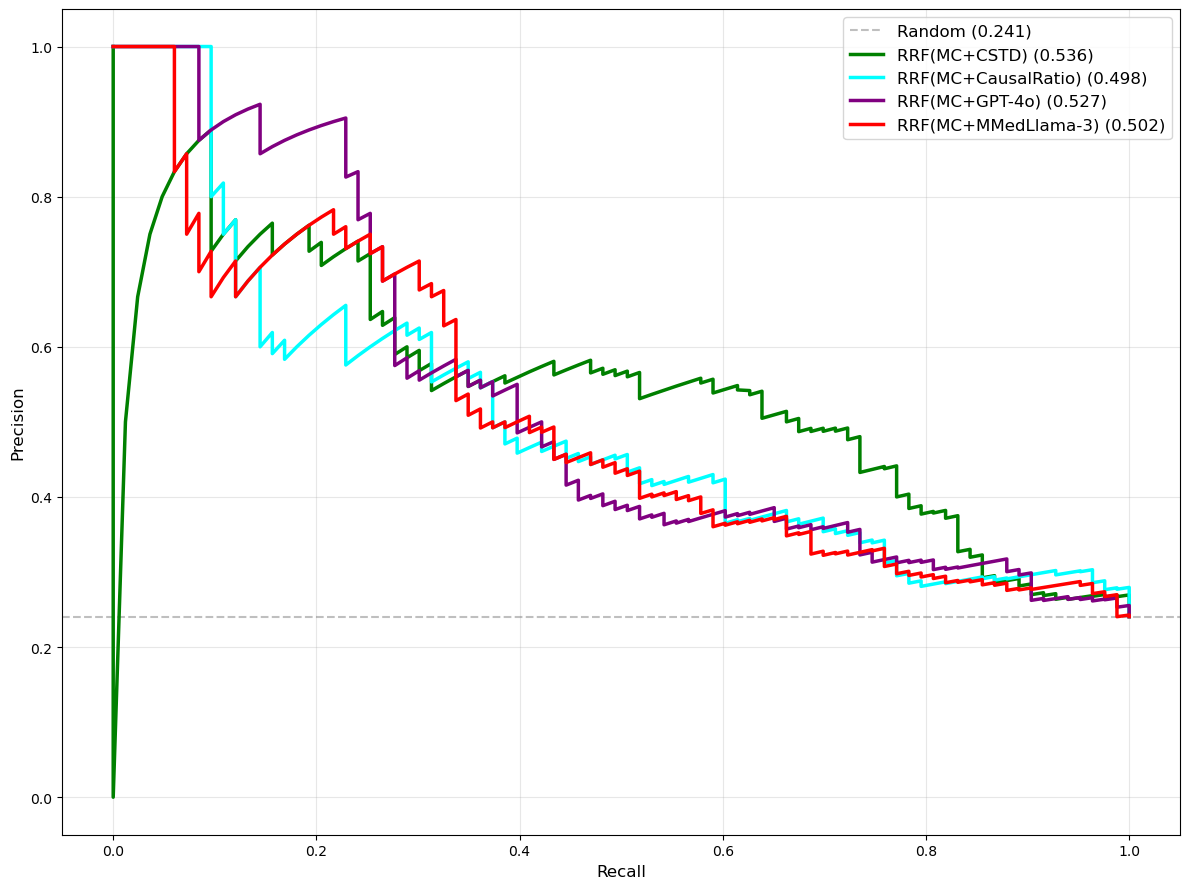

  💾 Saved: /data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/disease_wise_reports/plots/pr_curve_All_Diseases_Combined.png

Generating overall Recall@K curve...


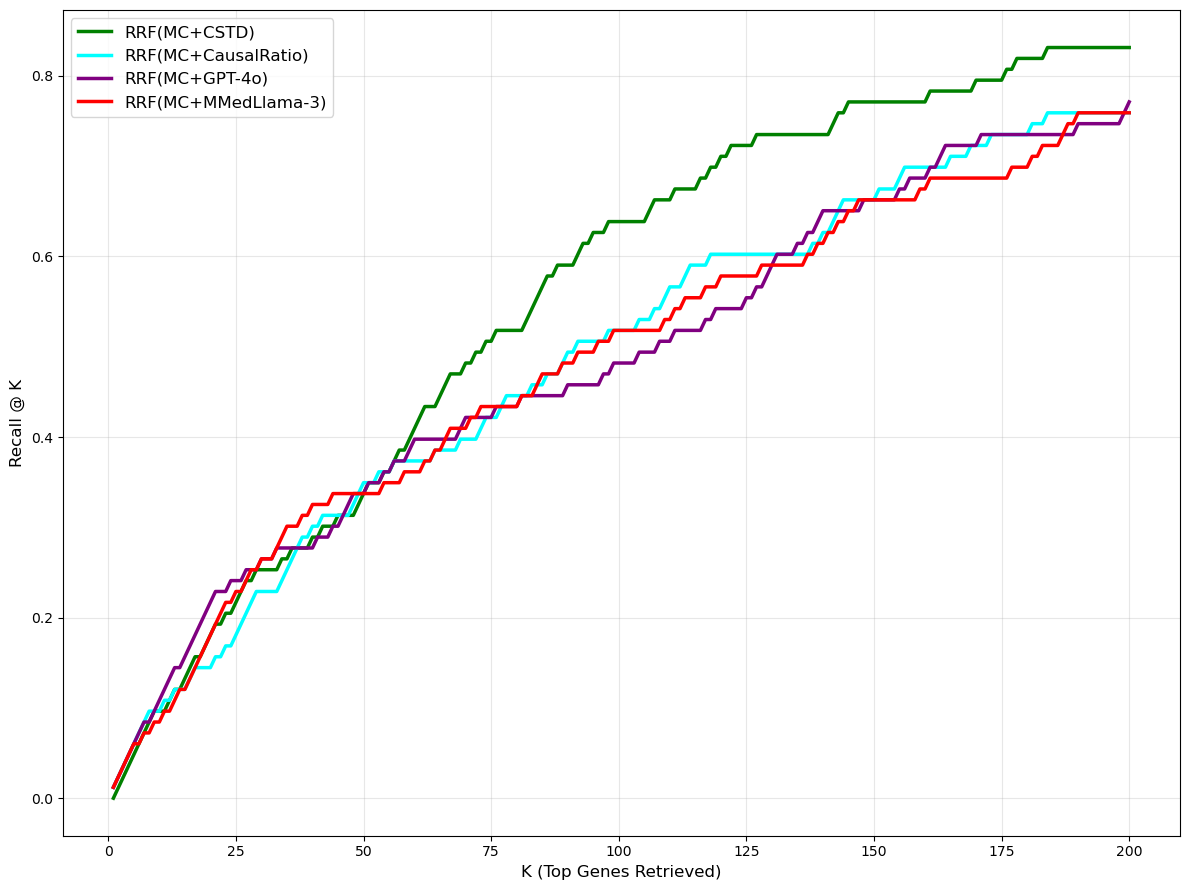

  💾 Saved: /data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/disease_wise_reports/plots/recall_at_k_All_Diseases_Combined.png

Generating per-disease plots...

All outputs saved to: /data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/disease_wise_reports


In [24]:
#!/usr/bin/env python3
"""
Disease-Wise Report Generator
==============================
Generates comprehensive reports for each disease and method including:
- PR AUC
- Recall @K (20, 50, 100)
- Classification Report with optimal cutoffs
- Overall (global) classification matrix for all methods
- RRF (Reciprocal Rank Fusion) of all methods with MultiCens
- All scores scaled to 0-1 range
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, auc, 
    classification_report, precision_score, recall_score, f1_score,
    confusion_matrix
)
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
BASE_PATH = '/data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered'
RESULTS_FILE = "/data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/multicens_v17_fixed_results/result_data_v17.csv"
OUTPUT_DIR = os.path.join(BASE_PATH, 'disease_wise_reports')

# RRF constant (standard value)
K_RRF = 60

# Methods to combine with MultiCens for RRF (each gets its own RRF fusion)
RRF_PARTNER_METHODS = [
    ('VQ_star', 'CSTD'),
    ('Causal_Ratio', 'CausalRatio'),
    ('OpenAI', 'GPT-4o'),
    ('MedLLaMA', 'MMedLlaMA'),
    ('OpenAI_NoCRED', 'GPT-4o_NoCRED'),
    ('MedLLaMA_NoCRED', 'MMedLlaMA_NoCRED')
]

# Base methods to analyze (will be extended with RRF combinations dynamically)
BASE_METHODS = [
    ('MultiCens_Score', 'MultiCens'),
    ('VQ_star', 'CSTD'),
    ('Causal_Ratio', 'CausalRatio'),
    ('OpenAI', 'GPT-4o'),
    ('MedLLaMA', 'MMedLlaMA'),
    ('OpenAI_NoCRED', 'GPT-4o_NoCRED'),
    ('MedLLaMA_NoCRED', 'MMedLlaMA_NoCRED')
]


def calculate_rrf_pairwise(df, method1, method2, k=60):
    """
    Calculate Reciprocal Rank Fusion (RRF) score combining exactly 2 methods.
    Uses pandas .rank() to match the original multicens_with_TD.py implementation.
    
    RRF formula: RRF(d) = sum over all rankings r: 1 / (k + r(d))
    where k is a constant (typically 60) and r(d) is the rank of document d in ranking r.
    
    Args:
        df: DataFrame with method scores
        method1: First method column name (e.g., 'MultiCens_Score')
        method2: Second method column name (e.g., 'VQ_star')
        k: RRF constant (default 60)
    
    Returns:
        Series with RRF scores for each row
    """
    # Use pandas rank() to match original implementation exactly
    r1 = df[method1].fillna(0).rank(ascending=False)
    r2 = df[method2].fillna(0).rank(ascending=False)
    
    rrf_scores = (1.0 / (k + r1)) + (1.0 / (k + r2))
    
    return rrf_scores


def calculate_recall_at_k(y_true, scores, k):
    """Calculate Recall@K."""
    if len(y_true) == 0 or np.sum(y_true) == 0:
        return 0.0
    
    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = np.array(y_true)[sorted_indices]
    
    top_k_labels = sorted_labels[:k]
    tp_at_k = np.sum(top_k_labels)
    total_positives = np.sum(y_true)
    
    return tp_at_k / total_positives if total_positives > 0 else 0.0


def calculate_pr_auc(y_true, scores):
    """Calculate PR-AUC."""
    if len(y_true) == 0 or np.sum(y_true) == 0:
        return 0.0
    
    try:
        precision, recall, _ = precision_recall_curve(y_true, scores)
        return auc(recall, precision)
    except:
        return 0.0


def find_optimal_threshold(y_true, scores):
    """Find optimal threshold that maximizes F1 score."""
    if len(y_true) == 0 or np.sum(y_true) == 0:
        return 0.5, {}
    
    try:
        precision, recall, thresholds = precision_recall_curve(y_true, scores)
        
        # Calculate F1 for each threshold
        f1_scores = []
        for i in range(len(thresholds)):
            if precision[i] + recall[i] > 0:
                f1 = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
            else:
                f1 = 0
            f1_scores.append(f1)
        
        if len(f1_scores) == 0:
            return 0.5, {}
        
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
        
        # Generate predictions with optimal threshold
        y_pred = (scores >= best_threshold).astype(int)
        
        return best_threshold, {
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'threshold': best_threshold
        }
    except:
        return 0.5, {}


def generate_classification_report_at_threshold(y_true, scores, threshold):
    """Generate classification report at a specific threshold."""
    y_pred = (scores >= threshold).astype(int)
    
    try:
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        return report
    except:
        return {}


def plot_pr_curve_all_methods(df, methods, output_dir, title_suffix=''):
    """
    Generate and save PR curve for all methods.
    
    Args:
        df: DataFrame with method scores and labels
        methods: List of (col_name, display_name) tuples
        output_dir: Directory to save plot
        title_suffix: Optional suffix for title (e.g., disease name)
    """
    y_true = df['label'].astype(int).values
    if np.sum(y_true) == 0:
        return None
    
    fig, ax = plt.subplots(figsize=(12, 9))
    pos_rate = y_true.mean()
    ax.axhline(y=pos_rate, ls='--', color='gray', alpha=0.5, label=f'Random ({pos_rate:.3f})')
    
    # Distinct color mapping for each RRF method
    method_colors = {
        'RRF(MC+CSTD)': 'green',           # Sea Green
        'RRF(MC+CausalRatio)': 'cyan',    # Tomato Red
        'RRF(MC+GPT-4o)': 'purple',         # Medium Purple
        'RRF(MC+MMedLlaMA)': 'red',      # Dark Orange
        'RRF(MC+GPT-4o_NoCRED)': '#20B2AA',  # Light Sea Green
        'RRF(MC+MMedLlaMA_NoCRED)': '#DC143C', # Crimson
    }
    
    # Fallback colors for any other methods
    # fallback_colors = ['#4169E1', '#32CD32', '#FF1493', '#00CED1', '#FFD700', '#8B4513']
    fallback_colors = ['red']
    
    
    auc_scores = {}
    color_idx = 0
    for col, label in methods:
        # Only plot RRF fusion methods (skip single methods)
        if not label.startswith('RRF('):
            continue
            
        if col not in df.columns:
            continue
        scores = df[col].fillna(0).values
        if np.all(scores == 0):
            continue
        
        precision, recall, _ = precision_recall_curve(y_true, scores)
        auc_val = auc(recall, precision)
        auc_scores[label] = auc_val
        
        # Get color from mapping or fallback
        color = method_colors.get(label, fallback_colors[color_idx % len(fallback_colors)])
        color_idx += 1
        
        ax.plot(recall, precision, lw=2.5, color=color, label=f'{label} ({auc_val:.3f})')
    
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    title = f'Precision-Recall Curve: All Methods{" - " + title_suffix if title_suffix else ""}'
    # ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, alpha=0.3)
    # ax.set_xlim([0, 1])
    # ax.set_ylim([0, 1])
    
    plt.tight_layout()
    safe_suffix = title_suffix.replace(' ', '_').replace('/', '_') if title_suffix else 'overall'
    filename = os.path.join(output_dir, f'pr_curve_{safe_suffix}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return auc_scores, filename


def plot_recall_at_k_all_methods(df, methods, output_dir, max_k=200, title_suffix=''):
    """
    Generate and save Recall@K curve for all methods.
    
    Args:
        df: DataFrame with method scores and labels
        methods: List of (col_name, display_name) tuples
        output_dir: Directory to save plot
        max_k: Maximum K value to plot
        title_suffix: Optional suffix for title
    """
    y_true = df['label'].astype(int).values
    total_positives = np.sum(y_true)
    if total_positives == 0:
        return None
    
    max_k = min(max_k, len(y_true))
    x_k = np.arange(1, max_k + 1)
    
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Distinct color mapping for each RRF method
    method_colors = {
        'RRF(MC+CSTD)': 'green',           # Sea Green
        'RRF(MC+CausalRatio)': 'cyan',    # Tomato Red
        'RRF(MC+GPT-4o)': 'purple',         # Medium Purple
        'RRF(MC+MMedLlaMA)': 'red',      # Dark Orange
        'RRF(MC+GPT-4o_NoCRED)': '#20B2AA',  # Light Sea Green
        'RRF(MC+MMedLlaMA_NoCRED)': '#DC143C', # Crimson
    }

    
    # Fallback colors for any other methods
    # fallback_colors = ['#4169E1', '#32CD32', '#FF1493', '#00CED1', '#FFD700', '#8B4513']
    fallback_colors = ['red']
    
    
    color_idx = 0
    for col, label in methods:
        # Only plot RRF fusion methods (skip single methods)
        if not label.startswith('RRF('):
            continue
            
        if col not in df.columns:
            continue
        scores = df[col].fillna(0).values
        if np.all(scores == 0):
            continue
        
        sorted_indices = np.argsort(scores)[::-1]
        sorted_labels = y_true[sorted_indices]
        cum_tp = np.cumsum(sorted_labels)
        recall_at_k = cum_tp[:max_k] / total_positives
        
        # Get color from mapping or fallback
        color = method_colors.get(label, fallback_colors[color_idx % len(fallback_colors)])
        color_idx += 1
        
        ax.plot(x_k, recall_at_k, lw=2.5, color=color, label=f'{label}')
    
    ax.set_xlabel('K (Top Genes Retrieved)', fontsize=12)
    ax.set_ylabel('Recall @ K', fontsize=12)
    title = f'Recall @ K: All Methods{" - " + title_suffix if title_suffix else ""}'
    # ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    # ax.set_xlim([1, max_k])
    # ax.set_ylim([0, 1])
    
    plt.tight_layout()
    safe_suffix = title_suffix.replace(' ', '_').replace('/', '_') if title_suffix else 'overall'
    filename = os.path.join(output_dir, f'recall_at_k_{safe_suffix}.png')
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return filename


def main():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print("=" * 80)
    print("DISEASE-WISE REPORT GENERATOR")
    print("=" * 80)
    
    # Load data
    if not os.path.exists(RESULTS_FILE):
        print(f"ERROR: Results file not found: {RESULTS_FILE}")
        print("Please run multicens_with_TD.py first to generate results.")
        return
    
    df = pd.read_csv(RESULTS_FILE)
    print(f"\nLoaded {len(df)} rows from results file")
    print(f"Diseases: {df['disease'].nunique()}")
    print(f"Base methods available: {[m[0] for m in BASE_METHODS if m[0] in df.columns]}")
    
    # Filter valid samples
    df = df[df['label'].notna() & (df['paper_count'] > 1)].copy()
    print(f"After filtering: {len(df)} rows")
    
    # Calculate RRF of MultiCens with EACH method individually
    # Matching multicens_with_TD.py logic exactly:
    # - Fusion_RRF (MC+CSTD) already exists in data (calculated before filtering and scaled)
    # - For other methods, calculate RRF using same logic then scale
    # print("\n" + "=" * 80)
    # print("CALCULATING RRF OF MULTICENS WITH EACH METHOD")
    # print("=" * 80)
    
    # Use existing Fusion_RRF for MC+CSTD (already correctly calculated and scaled in source)
    # if 'Fusion_RRF' in df.columns:
    #     print(f"Fusion_RRF (MC+CSTD) from source: range [{df['Fusion_RRF'].min():.6f}, {df['Fusion_RRF'].max():.6f}]")
    
    # Other partner methods to combine with MultiCens via RRF
    other_partner_methods = [
        ('Causal_Ratio', 'CausalRatio'),
        ('OpenAI', 'GPT-4o'),
        ('MedLLaMA', 'MMedLlama-3')
    ]
        #     ('OpenAI_NoCRED', 'GPT-4o_NoCRED'),
        # ('MedLLaMA_NoCRED', 'MMedLlaMA_NoCRED')
    
    # Calculate RRF for other methods using same logic as multicens_with_TD.py
    rrf_columns = []
    for method_col, method_name in other_partner_methods:
        if method_col in df.columns and 'MultiCens_Score' in df.columns:
            rrf_col_name = f'RRF_MultiCens_{method_name}'
            # Use pandas rank() exactly like multicens_with_TD.py
            r1 = df['MultiCens_Score'].fillna(0).rank(ascending=False)
            r2 = df[method_col].fillna(0).rank(ascending=False)
            df[rrf_col_name] = (1.0 / (K_RRF + r1)) + (1.0 / (K_RRF + r2))
            rrf_columns.append(rrf_col_name)
            # print(f"{rrf_col_name}: raw range [{df[rrf_col_name].min():.6f}, {df[rrf_col_name].max():.6f}]")
    
    # Scale new RRF columns to 0-1 (matching scale_scores in multicens_with_TD.py)
    for col in rrf_columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df[col] = (df[col] - min_val) / (max_val - min_val)
            # print(f"  -> {col} scaled to [0, 1]")
    
    # Build complete METHODS list: Fusion_RRF first, then other RRF combinations, then base methods
    METHODS = [('Fusion_RRF', 'RRF(MC+CSTD)')]  # Use existing Fusion_RRF
    
    for method_col, method_name in other_partner_methods:
        rrf_col_name = f'RRF_MultiCens_{method_name}'
        if rrf_col_name in df.columns:
            METHODS.append((rrf_col_name, f'RRF(MC+{method_name})'))
    
    # Add base methods
    METHODS.extend(BASE_METHODS)

    # Add Random Classifier
    np.random.seed(42)  # For reproducibility
    df['Random_Score'] = np.random.uniform(0, 1, size=len(df))
    METHODS.append(('Random_Score', 'Random_Classifier'))
    
    # print(f"\nTotal methods to analyze: {len(METHODS)}")
    
    # Scale ALL method scores to 0-1 range
    # Use QuantileTransformer for skewed distributions (like MultiCens_Score)
    # and MinMaxScaler for already well-distributed scores
    # print("\n" + "=" * 80)
    # print("SCALING ALL METHOD SCORES to 0-1 range")
    # print("=" * 80)
    
    from sklearn.preprocessing import QuantileTransformer
    
    # Columns with highly skewed distributions - use QuantileTransformer
    skewed_columns = ['MultiCens_Score', 'Fusion_RRF'] + rrf_columns
    
    # Other columns - use MinMaxScaler  
    normal_columns = ['VQ_star', 'Causal_Ratio', 'OpenAI', 'MedLLaMA', 'OpenAI_NoCRED', 'MedLLaMA_NoCRED']
    
    # Apply QuantileTransformer for skewed columns (uniform output)
    qt = QuantileTransformer(output_distribution='uniform', random_state=42)
    for col in skewed_columns:
        if col in df.columns:
            orig_median = df[col].median()
            df[col] = qt.fit_transform(df[[col]])
            new_median = df[col].median()
            print(f"{col}: QuantileTransform (median: {orig_median:.4f} -> {new_median:.4f})")
    
    # Apply MinMaxScaler for normal columns
    scaler = MinMaxScaler()
    for col in normal_columns:
        if col in df.columns:
            orig_min = df[col].min()
            orig_max = df[col].max()
            if orig_max > orig_min:
                df[col] = scaler.fit_transform(df[[col]])
                print(f"{col}: MinMaxScale [{orig_min:.4f}, {orig_max:.4f}] -> [0, 1]")
                
    final_scaled_results = os.path.join(OUTPUT_DIR, 'final_scaled_results_all_methods.csv')
    df.to_csv('final_scaled_results', index=False)
    print("Scores of all methods saved in inal_scaled_results_all_methods.csv file")

    
    diseases = df['disease'].unique()
    
    # Storage for all results
    all_metrics = []
    all_classification_reports = []
    
    # print("\n" + "=" * 80)
    # print("PROCESSING DISEASES")
    # print("=" * 80)
    
    for disease in diseases:
        disease_df = df[df['disease'] == disease].copy()
        
        # if len(disease_df) < 5:
        #     print(f"\nSkipping {disease}: Too few samples ({len(disease_df)})")
        #     continue
        
        y_true = disease_df['label'].astype(int).values
        n_positives = np.sum(y_true)
        
        # if n_positives == 0:
        #     print(f"\nSkipping {disease}: No positive samples")
        #     continue
        
        # print(f"\n{'='*60}")
        # print(f"DISEASE: {disease}")
        # print(f"{'='*60}")
        # print(f"Total genes: {len(disease_df)}, Positives: {n_positives}")
        
        for method_col, method_name in METHODS:
            # print(method_name,"-------")
            if method_col not in disease_df.columns and  method_name=="MedLLaMA":
                continue
            
            scores = disease_df[method_col].fillna(0).values
            
            if np.all(scores == 0):
                continue
            
            # Calculate metrics
            pr_auc = calculate_pr_auc(y_true, scores)
            recall_20 = calculate_recall_at_k(y_true, scores, 20)
            recall_50 = calculate_recall_at_k(y_true, scores, 50)
            recall_100 = calculate_recall_at_k(y_true, scores, 100)
            
            # Find optimal threshold and metrics
            opt_threshold, opt_metrics = find_optimal_threshold(y_true, scores)
            # print("----",opt_threshold)
            
            # Store metrics
            all_metrics.append({
                'Disease': disease,
                'Method': method_name,
                'PR_AUC': pr_auc,
                'Recall@20': recall_20,
                'Recall@50': recall_50,
                'Recall@100': recall_100,
                'Optimal_Threshold': opt_threshold,
                'Precision@OptThresh': opt_metrics.get('precision', 0),
                'Recall@OptThresh': opt_metrics.get('recall', 0),
                'F1@OptThresh': opt_metrics.get('f1', 0),
                'N_Genes': len(disease_df),
                'N_Positives': n_positives
            })
            
            # Generate classification report at optimal threshold
            cls_report = generate_classification_report_at_threshold(y_true, scores, opt_threshold)
            if cls_report:
                all_classification_reports.append({
                    'Disease': disease,
                    'Method': method_name,
                    'Threshold': opt_threshold,
                    'Class_0_Precision': cls_report.get('0', {}).get('precision', 0),
                    'Class_0_Recall': cls_report.get('0', {}).get('recall', 0),
                    'Class_0_F1': cls_report.get('0', {}).get('f1-score', 0),
                    'Class_0_Support': cls_report.get('0', {}).get('support', 0),
                    'Class_1_Precision': cls_report.get('1', {}).get('precision', 0),
                    'Class_1_Recall': cls_report.get('1', {}).get('recall', 0),
                    'Class_1_F1': cls_report.get('1', {}).get('f1-score', 0),
                    'Class_1_Support': cls_report.get('1', {}).get('support', 0),
                    'Macro_F1': cls_report.get('macro avg', {}).get('f1-score', 0),
                    'Weighted_F1': cls_report.get('weighted avg', {}).get('f1-score', 0),
                    'Accuracy': cls_report.get('accuracy', 0)
                })
        
        # Print summary for this disease
        disease_metrics = [m for m in all_metrics if m['Disease'] == disease]
        # if disease_metrics:
        #     print(f"\n{'Method':<25} {'PR_AUC':>8} {'R@20':>8} {'R@50':>8} {'R@100':>8} {'F1@Opt':>8}")
        #     print("-" * 75)
        #     for m in disease_metrics:
        #         print(f"{m['Method']:<25} {m['PR_AUC']:>8.4f} {m['Recall@20']:>8.4f} {m['Recall@50']:>8.4f} {m['Recall@100']:>8.4f} {m['F1@OptThresh']:>8.4f}")
    
    # Create DataFrames
    metrics_df = pd.DataFrame(all_metrics)
    cls_reports_df = pd.DataFrame(all_classification_reports)
    
    # Save detailed results
    metrics_file = os.path.join(OUTPUT_DIR, 'disease_wise_metrics.csv')
    cls_report_file = os.path.join(OUTPUT_DIR, 'disease_wise_classification_reports.csv')
    
    metrics_df.to_csv(metrics_file, index=False)
    cls_reports_df.to_csv(cls_report_file, index=False)
    
    # print(f"\n\n{'='*80}")
    # print("SAVED FILES")
    # print("=" * 80)
    # print(f"1. Metrics: {metrics_file}")
    # print(f"2. Classification Reports: {cls_report_file}")
    
    # Generate GLOBAL summary statistics (calculated on ALL data at once, not mean)
    print("\n\n" + "=" * 80)
    print("GLOBAL SUMMARY STATISTICS (CALCULATED ON ALL DATA COMBINED)")
    print("=" * 80)
    
    y_true_all = df['label'].astype(int).values
    print(f"\nTotal samples: {len(y_true_all)}")
    print(f"Total positives: {np.sum(y_true_all)}")
    print(f"Total negatives: {len(y_true_all) - np.sum(y_true_all)}")
    
    global_summary_data = []
    
    for method_col, method_name in METHODS:
        if method_col not in df.columns:
            continue
        
        scores = df[method_col].fillna(0).values
        
        if np.all(scores == 0):
            continue
        
        # Calculate global metrics on ALL data at once
        pr_auc = calculate_pr_auc(y_true_all, scores)
        recall_20 = calculate_recall_at_k(y_true_all, scores, 20)
        recall_50 = calculate_recall_at_k(y_true_all, scores, 50)
        recall_100 = calculate_recall_at_k(y_true_all, scores, 100)
        
        # Find optimal threshold and metrics globally
        opt_threshold, opt_metrics = find_optimal_threshold(y_true_all, scores)
        
        global_summary_data.append({
            'Method': method_name,
            'PR_AUC': pr_auc,
            'Recall@20': recall_20,
            'Recall@50': recall_50,
            'Recall@100': recall_100,
            'Optimal_Threshold': opt_threshold,
            'Precision@OptThresh': opt_metrics.get('precision', 0),
            'Recall@OptThresh': opt_metrics.get('recall', 0),
            'F1@OptThresh': opt_metrics.get('f1', 0)
        })
    
    summary = pd.DataFrame(global_summary_data).set_index('Method')
    # print("\n" + summary.round(4).to_string())
    
    summary_file = os.path.join(OUTPUT_DIR, 'method_summary_stats.csv')
    summary.to_csv(summary_file)
    # print(f"\nGlobal summary saved to: {summary_file}")
    
    # Generate per-disease pivot tables for key metrics
    # print("\n\n" + "=" * 80)
    # print("PR-AUC BY DISEASE AND METHOD")
    # print("=" * 80)
    
    pr_auc_pivot = metrics_df.pivot_table(
        values='PR_AUC', 
        index='Disease', 
        columns='Method', 
        aggfunc='first'
    ).round(4)
    
    # print(pr_auc_pivot.to_string())
    pr_auc_pivot.to_csv(os.path.join(OUTPUT_DIR, 'pr_auc_by_disease.csv'))
    
    # print("\n\n" + "=" * 80)
    # print("RECALL@20 BY DISEASE AND METHOD")
    # print("=" * 80)
    
    recall20_pivot = metrics_df.pivot_table(
        values='Recall@20', 
        index='Disease', 
        columns='Method', 
        aggfunc='first'
    ).round(4)
    
    # print(recall20_pivot.to_string())
    recall20_pivot.to_csv(os.path.join(OUTPUT_DIR, 'recall_at_20_by_disease.csv'))
    
    # print("\n\n" + "=" * 80)
    # print("RECALL@50 BY DISEASE AND METHOD")
    # print("=" * 80)
    
    recall50_pivot = metrics_df.pivot_table(
        values='Recall@50', 
        index='Disease', 
        columns='Method', 
        aggfunc='first'
    ).round(4)
    
    # print(recall50_pivot.to_string())
    recall50_pivot.to_csv(os.path.join(OUTPUT_DIR, 'recall_at_50_by_disease.csv'))
    
    # print("\n\n" + "=" * 80)
    # print("RECALL@100 BY DISEASE AND METHOD")
    # print("=" * 80)
    
    recall100_pivot = metrics_df.pivot_table(
        values='Recall@100', 
        index='Disease', 
        columns='Method', 
        aggfunc='first'
    ).round(4)
    
    # print(recall100_pivot.to_string())
    recall100_pivot.to_csv(os.path.join(OUTPUT_DIR, 'recall_at_100_by_disease.csv'))
    
    # print("\n\n" + "=" * 80)
    # print("F1@OPTIMAL THRESHOLD BY DISEASE AND METHOD")
    # print("=" * 80)
    
    f1_pivot = metrics_df.pivot_table(
        values='F1@OptThresh', 
        index='Disease', 
        columns='Method', 
        aggfunc='first'
    ).round(4)
    
    # print(f1_pivot.to_string())
    f1_pivot.to_csv(os.path.join(OUTPUT_DIR, 'f1_optimal_by_disease.csv'))
    
    # Best performing method per disease
    # print("\n\n" + "=" * 80)
    # print("BEST METHOD PER DISEASE (BY PR-AUC)")
    # print("=" * 80)
    
    best_by_disease = metrics_df.loc[metrics_df.groupby('Disease')['PR_AUC'].idxmax()][['Disease', 'Method', 'PR_AUC']]
    # print(best_by_disease.to_string(index=False))
    
    # Method win counts
    # print("\n\nMethod Win Counts (Best PR-AUC):")
    # print(best_by_disease['Method'].value_counts().to_string())
    
    # ==========================================================================
    # OVERALL (GLOBAL) CLASSIFICATION MATRIX FOR ALL METHODS
    # ==========================================================================
    # print("\n\n" + "=" * 80)
    # print("OVERALL CLASSIFICATION MATRIX (ALL DATA - SKLEARN STYLE)")
    # print("=" * 80)
    
    y_true_all = df['label'].astype(int).values
    overall_report_data = []
    
    # print(f"\nTotal samples: {len(y_true_all)}")
    # print(f"Total positives: {np.sum(y_true_all)}")
    # print(f"Total negatives: {len(y_true_all) - np.sum(y_true_all)}")
    
    for method_col, method_name in METHODS:
        if method_col not in df.columns:
            continue
        # print(df.isna().sum())
        # print(df[method_col])
        scores = df[method_col].values
        
        if np.all(scores == 0):
            continue
        
        # Find optimal threshold for this method globally
        opt_threshold, _ = find_optimal_threshold(y_true_all, scores)
        y_pred = (scores >= opt_threshold).astype(int)
        
        # Get sklearn-style classification report
        print(f"\n{'='*60}")
        print(f"METHOD: {method_name}")
        print(f"{'='*60}")
        print(f"Optimal Threshold: {opt_threshold:.4f}")
        print()
        
        # Print sklearn-style classification report
        report_str = classification_report(y_true_all, y_pred, 
                                           target_names=['Non-Causal (0)', 'Causal (1)'],
                                           zero_division=0)
        # print(report_str)
        
        # Print confusion matrix
        cm = confusion_matrix(y_true_all, y_pred)
        print("Confusion Matrix:")
        print(f"                    Predicted")
        print(f"                    0       1")
        print(f"Actual  0     {cm[0,0]:>6}  {cm[0,1]:>6}")
        print(f"        1     {cm[1,0]:>6}  {cm[1,1]:>6}")
        
        # Calculate PR-AUC for this method
        pr_auc = calculate_pr_auc(y_true_all, scores)

        # Store overall report data (use numeric keys for output_dict)
        report_dict = classification_report(y_true_all, y_pred, output_dict=True, zero_division=0)
        overall_report_data.append({
            'Method': method_name,
            'Optimal_Threshold': opt_threshold,
            'Non_Causal_Precision': report_dict.get('0', {}).get('precision', 0),
            'Non_Causal_Recall': report_dict.get('0', {}).get('recall', 0),
            'Non_Causal_F1': report_dict.get('0', {}).get('f1-score', 0),
            'Non_Causal_Support': report_dict.get('0', {}).get('support', 0),
            'Causal_Precision': report_dict.get('1', {}).get('precision', 0),
            'Causal_Recall': report_dict.get('1', {}).get('recall', 0),
            'Causal_F1': report_dict.get('1', {}).get('f1-score', 0),
            'Causal_Support': report_dict.get('1', {}).get('support', 0),
            'Macro_Precision': report_dict.get('macro avg', {}).get('precision', 0),
            'Macro_Recall': report_dict.get('macro avg', {}).get('recall', 0),
            'Macro_F1': report_dict.get('macro avg', {}).get('f1-score', 0),
            'Weighted_F1': report_dict.get('weighted avg', {}).get('f1-score', 0),
            'Accuracy': report_dict.get('accuracy', 0),
            'TN': cm[0,0],
            'FP': cm[0,1],
            'FN': cm[1,0],
            'TP': cm[1,1],
            'PR_AUC': pr_auc
        })
    
    # Save overall classification reports to CSV
    overall_report_df = pd.DataFrame(overall_report_data)
    overall_report_file = os.path.join(OUTPUT_DIR, 'overall_classification_matrix.csv')
    overall_report_df.to_csv(overall_report_file, index=False)
    print(f"\n\nOverall classification matrix saved to: {overall_report_file}")
    
    # Print summary table
    # print("\n\n" + "=" * 80)
    # print("OVERALL CLASSIFICATION SUMMARY (ALL METHODS)")
    # print("=" * 80)
    
    summary_cols = ['Method', 'Accuracy', 'Macro_Precision', 'Macro_Recall', 'Macro_F1', 'Causal_Precision', 'Causal_Recall', 'Causal_F1', 'PR_AUC']
    print(overall_report_df[summary_cols].round(4).to_string(index=False))
    
    # ==========================================================================
    # GENERATE PR AND RECALL@K PLOTS
    # ==========================================================================
    print("\n\n" + "=" * 80)
    print("GENERATING PR CURVE AND RECALL@K PLOTS")
    print("=" * 80)
    
    # Create plots directory
    plots_dir = os.path.join(OUTPUT_DIR, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # Generate OVERALL PR curve (all data combined)
    print("\nGenerating overall PR curve...")
    pr_result = plot_pr_curve_all_methods(df, METHODS, plots_dir, title_suffix='All Diseases Combined')
    if pr_result:
        auc_scores, pr_file = pr_result
        print(f"  💾 Saved: {pr_file}")
        # print("  AUC Scores:")
        # for method, auc_val in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
        #     print(f"    {method}: {auc_val:.4f}")
    
    # Generate OVERALL Recall@K curve
    print("\nGenerating overall Recall@K curve...")
    recall_file = plot_recall_at_k_all_methods(df, METHODS, plots_dir, max_k=200, title_suffix='All Diseases Combined')
    if recall_file:
        print(f"  💾 Saved: {recall_file}")
    
    # Generate PER-DISEASE plots
    print("\nGenerating per-disease plots...")
    disease_plots_dir = os.path.join(plots_dir, 'disease_plots')
    os.makedirs(disease_plots_dir, exist_ok=True)
    
    # for disease in diseases:
    #     disease_df = df[df['disease'] == disease].copy()
    #     if len(disease_df) < 5:
    #         continue
        
    #     y_true = disease_df['label'].astype(int).values
    #     if np.sum(y_true) == 0:
    #         continue
        
    #     # PR curve for this disease
    #     pr_result = plot_pr_curve_all_methods(disease_df, METHODS, disease_plots_dir, title_suffix=disease)
    #     if pr_result:
    #         print(f"  📊 {disease}: PR curve saved")
        
    #     # Recall@K curve for this disease
    #     max_k_disease = min(100, len(disease_df))
    #     recall_file = plot_recall_at_k_all_methods(disease_df, METHODS, disease_plots_dir, max_k=max_k_disease, title_suffix=disease)
    #     if recall_file:
    #         print(f"  📊 {disease}: Recall@K curve saved")
    
    # print(f"\n✅ All plots saved to: {plots_dir}")
    
    # print("\n\n" + "=" * 80)
    # print("REPORT GENERATION COMPLETE")
    # print("=" * 80)
    print(f"\nAll outputs saved to: {OUTPUT_DIR}")


if __name__ == "__main__":
    main()


In [26]:


print("=" * 80)
print("DISEASE-WISE REPORT GENERATOR")
print("=" * 80)

# # Load data
# if not os.path.exists(RESULTS_FILE):
#     print(f"ERROR: Results file not found: {RESULTS_FILE}")
#     print("Please run multicens_with_TD.py first to generate results.")
#     return

df = pd.read_csv(RESULTS_FILE)
print(f"\nLoaded {len(df)} rows from results file")
print(f"Diseases: {df['disease'].nunique()}")
print(f"Base methods available: {[m[0] for m in BASE_METHODS if m[0] in df.columns]}")

# Filter valid samples
df = df[df['label'].notna() & (df['paper_count'] > 1)].copy()
print(f"After filtering: {len(df)} rows")

# Calculate RRF of MultiCens with EACH method individually
# Matching multicens_with_TD.py logic exactly:
# - Fusion_RRF (MC+CSTD) already exists in data (calculated before filtering and scaled)
# - For other methods, calculate RRF using same logic then scale
print("\n" + "=" * 80)
print("CALCULATING RRF OF MULTICENS WITH EACH METHOD")
print("=" * 80)

# Use existing Fusion_RRF for MC+CSTD (already correctly calculated and scaled in source)
# if 'Fusion_RRF' in df.columns:
#     print(f"Fusion_RRF (MC+CSTD) from source: range [{df['Fusion_RRF'].min():.6f}, {df['Fusion_RRF'].max():.6f}]")

# Other partner methods to combine with MultiCens via RRF
other_partner_methods = [
    ('Causal_Ratio', 'CausalRatio'),
    ('OpenAI', 'GPT-4o'),
    ('MedLLaMA', 'MMedLlama-3')
]
    #     ('OpenAI_NoCRED', 'GPT-4o_NoCRED'),
    # ('MedLLaMA_NoCRED', 'MMedLlaMA_NoCRED')

# Calculate RRF for other methods using same logic as multicens_with_TD.py
rrf_columns = []
for method_col, method_name in other_partner_methods:
    if method_col in df.columns and 'MultiCens_Score' in df.columns:
        rrf_col_name = f'RRF_MultiCens_{method_name}'
        # Use pandas rank() exactly like multicens_with_TD.py
        r1 = df['MultiCens_Score'].fillna(0).rank(ascending=False)
        r2 = df[method_col].fillna(0).rank(ascending=False)
        df[rrf_col_name] = (1.0 / (K_RRF + r1)) + (1.0 / (K_RRF + r2))
        rrf_columns.append(rrf_col_name)
        print(f"{rrf_col_name}: raw range [{df[rrf_col_name].min():.6f}, {df[rrf_col_name].max():.6f}]")

# Scale new RRF columns to 0-1 (matching scale_scores in multicens_with_TD.py)
for col in rrf_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    if max_val > min_val:
        df[col] = (df[col] - min_val) / (max_val - min_val)
        print(f"  -> {col} scaled to [0, 1]")

# Build complete METHODS list: Fusion_RRF first, then other RRF combinations, then base methods
METHODS = [('Fusion_RRF', 'RRF(MC+CSTD)')]  # Use existing Fusion_RRF

for method_col, method_name in other_partner_methods:
    rrf_col_name = f'RRF_MultiCens_{method_name}'
    if rrf_col_name in df.columns:
        METHODS.append((rrf_col_name, f'RRF(MC+{method_name})'))

# Add base methods
METHODS.extend(BASE_METHODS)

# Add Random Classifier
np.random.seed(42)  # For reproducibility
df['Random_Score'] = np.random.uniform(0, 1, size=len(df))
METHODS.append(('Random_Score', 'Random_Classifier'))

print(f"\nTotal methods to analyze: {len(METHODS)}")

# Scale ALL method scores to 0-1 range
# Use QuantileTransformer for skewed distributions (like MultiCens_Score)
# and MinMaxScaler for already well-distributed scores
print("\n" + "=" * 80)
print("SCALING ALL METHOD SCORES to 0-1 range")
print("=" * 80)

from sklearn.preprocessing import QuantileTransformer

# Columns with highly skewed distributions - use QuantileTransformer
skewed_columns = ['MultiCens_Score', 'Fusion_RRF'] + rrf_columns

# Other columns - use MinMaxScaler  
normal_columns = ['VQ_star', 'Causal_Ratio', 'OpenAI', 'MedLLaMA', 'OpenAI_NoCRED', 'MedLLaMA_NoCRED']

# Apply QuantileTransformer for skewed columns (uniform output)
qt = QuantileTransformer(output_distribution='uniform', random_state=42)
for col in skewed_columns:
    if col in df.columns:
        orig_median = df[col].median()
        df[col] = qt.fit_transform(df[[col]])
        new_median = df[col].median()
        print(f"{col}: QuantileTransform (median: {orig_median:.4f} -> {new_median:.4f})")

# Apply MinMaxScaler for normal columns
scaler = MinMaxScaler()
for col in normal_columns:
    if col in df.columns:
        orig_min = df[col].min()
        orig_max = df[col].max()
        if orig_max > orig_min:
            df[col] = scaler.fit_transform(df[[col]])
            print(f"{col}: MinMaxScale [{orig_min:.4f}, {orig_max:.4f}] -> [0, 1]")

diseases = df['disease'].unique()

# Storage for all results
all_metrics = []
all_classification_reports = []

print("\n" + "=" * 80)
print("PROCESSING DISEASES")
print("=" * 80)

DISEASE-WISE REPORT GENERATOR

Loaded 345 rows from results file
Diseases: 10
Base methods available: ['MultiCens_Score', 'VQ_star', 'Causal_Ratio', 'OpenAI', 'MedLLaMA', 'OpenAI_NoCRED', 'MedLLaMA_NoCRED']
After filtering: 345 rows

CALCULATING RRF OF MULTICENS WITH EACH METHOD
RRF_MultiCens_CausalRatio: raw range [0.005406, 0.027652]
RRF_MultiCens_GPT-4o: raw range [0.005001, 0.028079]
RRF_MultiCens_MMedLlama-3: raw range [0.005026, 0.030159]
  -> RRF_MultiCens_CausalRatio scaled to [0, 1]
  -> RRF_MultiCens_GPT-4o scaled to [0, 1]
  -> RRF_MultiCens_MMedLlama-3 scaled to [0, 1]

Total methods to analyze: 12

SCALING ALL METHOD SCORES to 0-1 range
MultiCens_Score: QuantileTransform (median: 0.0078 -> 0.5000)
Fusion_RRF: QuantileTransform (median: 0.4039 -> 0.5000)
RRF_MultiCens_CausalRatio: QuantileTransform (median: 0.1847 -> 0.5000)
RRF_MultiCens_GPT-4o: QuantileTransform (median: 0.1811 -> 0.5000)
RRF_MultiCens_MMedLlama-3: QuantileTransform (median: 0.1904 -> 0.5000)
VQ_star: Min

In [40]:
for disease in diseases:
        disease_df = df[df['disease'] == disease].copy()
        
        if len(disease_df) < 5:
            print(f"\nSkipping {disease}: Too few samples ({len(disease_df)})")
            continue
        
        y_true = disease_df['label'].astype(int).values
        n_positives = np.sum(y_true)
        
        if n_positives == 0:
            print(f"\nSkipping {disease}: No positive samples")
            continue
        
        print(f"\n{'='*60}")
        print(f"DISEASE: {disease}")
        print(f"{'='*60}")
        print(f"Total genes: {len(disease_df)}, Positives: {n_positives}")
        
        for method_col, method_name in METHODS:
            print(method_name,"-------")
            if method_col not in disease_df.columns :
                continue
            
            scores = disease_df[method_col].fillna(0).values
            
            if np.all(scores == 0):
                continue
            
            # Calculate metrics
            pr_auc = calculate_pr_auc(y_true, scores)
            recall_20 = calculate_recall_at_k(y_true, scores, 20)
            recall_50 = calculate_recall_at_k(y_true, scores, 50)
            recall_100 = calculate_recall_at_k(y_true, scores, 100)
            
            # Find optimal threshold and metrics
            opt_threshold, opt_metrics = find_optimal_threshold(y_true, scores)
            print(opt_threshold,)
            


DISEASE: Breast_cancer_somatic
Total genes: 99, Positives: 8
RRF(MC+CSTD) -------
0.6802325581395349
RRF(MC+CausalRatio) -------
0.7877906976744186
RRF(MC+GPT-4o) -------
0.7994186046511628
RRF(MC+MMedLlama-3) -------
0.8575581395348837
MultiCens -------
0.8837209302325582
CSTD -------
0.976915688114764
CausalRatio -------
0.25
GPT-4o -------
1.0
MMedLlaMA -------
0.0002155235629691
GPT-4o_NoCRED -------
0.9999999999999999
MMedLlaMA_NoCRED -------
1.0
Random_Classifier -------
0.9507143064099162

DISEASE: Colorectal_cancer_somatic
Total genes: 51, Positives: 13
RRF(MC+CSTD) -------
0.7180232558139542
RRF(MC+CausalRatio) -------
0.5
RRF(MC+GPT-4o) -------
0.3866279069767442
RRF(MC+MMedLlama-3) -------
0.3808139534883721
MultiCens -------
0.5348837209302326
CSTD -------
0.9539159356252246
CausalRatio -------
0.1666666666666666
GPT-4o -------
0.26666666666666666
MMedLlaMA -------
0.1463555644884499
GPT-4o_NoCRED -------
0.894736842105263
MMedLlaMA_NoCRED -------
0.0
Random_Classifier ---

## GPT-4o with CRED

In [46]:
df=pd.read_csv('/data/users/nency/truth_discovery/gene_discovery/gene_discovery/merged_correct_omim_filtered/multicens_v17_fixed_results/result_data_v17.csv')

print(f"\nLoaded {len(df)} rows from results file")
print(f"Diseases: {df['disease'].nunique()}")
print(f"Base methods available: {[m[0] for m in BASE_METHODS if m[0] in df.columns]}")

# Filter valid samples
df = df[df['label'].notna() & (df['paper_count'] > 1)].copy()
print(f"After filtering: {len(df)} rows")

# Calculate RRF of MultiCens with EACH method individually
# Matching multicens_with_TD.py logic exactly:
# - Fusion_RRF (MC+CSTD) already exists in data (calculated before filtering and scaled)
# - For other methods, calculate RRF using same logic then scale
print("\n" + "=" * 80)
print("CALCULATING RRF OF MULTICENS WITH EACH METHOD")
print("=" * 80)

# Use existing Fusion_RRF for MC+CSTD (already correctly calculated and scaled in source)
# if 'Fusion_RRF' in df.columns:
#     print(f"Fusion_RRF (MC+CSTD) from source: range [{df['Fusion_RRF'].min():.6f}, {df['Fusion_RRF'].max():.6f}]")

# Other partner methods to combine with MultiCens via RRF
other_partner_methods = [
    ('Causal_Ratio', 'CausalRatio'),
    ('OpenAI', 'GPT-4o'),
    ('MedLLaMA', 'MMedLlama-3')
]
    #     ('OpenAI_NoCRED', 'GPT-4o_NoCRED'),
    # ('MedLLaMA_NoCRED', 'MMedLlaMA_NoCRED')

# Calculate RRF for other methods using same logic as multicens_with_TD.py
rrf_columns = []
for method_col, method_name in other_partner_methods:
    if method_col in df.columns and 'MultiCens_Score' in df.columns:
        rrf_col_name = f'RRF_MultiCens_{method_name}'
        # Use pandas rank() exactly like multicens_with_TD.py
        r1 = df['MultiCens_Score'].fillna(0).rank(ascending=False)
        r2 = df[method_col].fillna(0).rank(ascending=False)
        df[rrf_col_name] = (1.0 / (K_RRF + r1)) + (1.0 / (K_RRF + r2))
        rrf_columns.append(rrf_col_name)
        print(f"{rrf_col_name}: raw range [{df[rrf_col_name].min():.6f}, {df[rrf_col_name].max():.6f}]")

# Scale new RRF columns to 0-1 (matching scale_scores in multicens_with_TD.py)
for col in rrf_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    if max_val > min_val:
        df[col] = (df[col] - min_val) / (max_val - min_val)
        print(f"  -> {col} scaled to [0, 1]")

# Build complete METHODS list: Fusion_RRF first, then other RRF combinations, then base methods
METHODS = [('Fusion_RRF', 'RRF(MC+CSTD)')]  # Use existing Fusion_RRF

for method_col, method_name in other_partner_methods:
    rrf_col_name = f'RRF_MultiCens_{method_name}'
    if rrf_col_name in df.columns:
        METHODS.append((rrf_col_name, f'RRF(MC+{method_name})'))

# Add base methods
METHODS.extend(BASE_METHODS)

# Add Random Classifier
np.random.seed(42)  # For reproducibility
df['Random_Score'] = np.random.uniform(0, 1, size=len(df))
METHODS.append(('Random_Score', 'Random_Classifier'))

print(f"\nTotal methods to analyze: {len(METHODS)}")

# Scale ALL method scores to 0-1 range
# Use QuantileTransformer for skewed distributions (like MultiCens_Score)
# and MinMaxScaler for already well-distributed scores
print("\n" + "=" * 80)
print("SCALING ALL METHOD SCORES to 0-1 range")
print("=" * 80)



Loaded 345 rows from results file
Diseases: 10
Base methods available: ['MultiCens_Score', 'VQ_star', 'Causal_Ratio', 'OpenAI', 'MedLLaMA', 'OpenAI_NoCRED', 'MedLLaMA_NoCRED']
After filtering: 345 rows

CALCULATING RRF OF MULTICENS WITH EACH METHOD
RRF_MultiCens_CausalRatio: raw range [0.005406, 0.027652]
RRF_MultiCens_GPT-4o: raw range [0.005001, 0.028079]
RRF_MultiCens_MMedLlama-3: raw range [0.005026, 0.028950]
  -> RRF_MultiCens_CausalRatio scaled to [0, 1]
  -> RRF_MultiCens_GPT-4o scaled to [0, 1]
  -> RRF_MultiCens_MMedLlama-3 scaled to [0, 1]

Total methods to analyze: 12

SCALING ALL METHOD SCORES to 0-1 range


In [24]:
import os
import json
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
from openai import AzureOpenAI
import concurrent.futures
import threading

# ==== Azure OpenAI Config ====
AZURE_OPENAI_API_KEY = "CqSAIM2DLgxvf6S58h8dOYHVKPzMdumoTXLeZMtzLWZhfkKtNkN8JQQJ99BFACF24PCXJ3w3AAABACOGe0ty"
AZURE_OPENAI_ENDPOINT = "https://teccspazureopenai.openai.azure.com/"
AZURE_DEPLOYMENT = "gpt-4o" 

# ==== Initialize Azure Client ====
client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-02-01"
)

# ==== Thread Safety & Custom JSON Encoding ====
log_lock = threading.Lock()

class NpEncoder(json.JSONEncoder):
    """Custom encoder to handle standard Pandas/Numpy types during JSON logging."""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if pd.isna(obj):
            return None
        return super(NpEncoder, self).default(obj)

# ============================
# ==== Load dataset ==========
# ============================
DATA_PATH = "complete_data_bibliometrics_with_all_diseases_biobert_svm_prediction_updated.tsv"
DATA_NAME = "All_disease"

try:
    data = pd.read_csv(DATA_PATH, sep='\t')
except FileNotFoundError:
    print("Warning: File not found. Creating dummy data for test.")
    # Added dummy pred_label and pred_proba for testing
    data = pd.DataFrame({
        "id1": ["GeneA"] * 5,
        "id2": [f"Disease{i}" for i in range(5)],
        "sentence": ["This gene causes disease."] * 5,
        "label": [1, 0, 1, 0, 1],
        "pred_label": [1, 0, 1, 0, 1],
        "pred_proba": [0.9, 0.2, 0.85, 0.1, 0.95]
    })

# Check for required columns
required_cols = {"id1", "id2", "sentence"}
if not required_cols.issubset(data.columns):
    raise ValueError(f"Missing basic columns. Found: {data.columns}")

# Ensure prediction columns exist (fill with N/A if missing to avoid crash)
if "pred_label" not in data.columns:
    data["pred_label"] = "N/A"
if "pred_proba" not in data.columns:
    data["pred_proba"] = "N/A"

# Find Ground Truth Label Column
LABEL_COL = None
for col in ["label", "Label", "labels", "Labels", "ground_truth", "class"]:
    if col in data.columns:
        LABEL_COL = col
        print(f"Found ground truth label column: '{LABEL_COL}'")
        break

# ============================
# ==== Grouping Logic Updated =
# ============================
grouped_data = []

# Group by Gene and Disease
for (id1, id2), group in data.groupby(["id1", "id2"]):
    
    # Construct a detailed evidence string containing Sentence + Model Preds
    evidence_list = []
    for index, row in group.iterrows():
        sent = row["sentence"]
        p_label = row.get("pred_label", "N/A")
        p_proba = row.get("pred_proba", "N/A")
        
        # Format: Text ... | Previous Model says: ...
        evidence_entry = f"- Text: \"{sent}\"\n  (Prior Model Prediction: {p_label}, Confidence: {p_proba})"
        evidence_list.append(evidence_entry)
        

    # Join all evidence for this pair
    full_evidence_context = "\n".join(evidence_list)
    print(full_evidence_context)
    
    # Get ground truth (mode or first)
    label = None
    if LABEL_COL:
        unique_labels = group[LABEL_COL].dropna().unique()
        if len(unique_labels) >= 1:
            label = group[LABEL_COL].mode().iloc[0] if not group[LABEL_COL].mode().empty else unique_labels[0]
    
    grouped_data.append({
        "id1": id1,
        "id2": id2,
        "evidence_context": full_evidence_context, # Renamed from 'sentences' to reflect richer data
        "original_label": label
    })

print(f"Processing {len(grouped_data)} unique gene-disease pairs...")

# ============================
# ==== Output Folder =========
# ============================
BASE_RESULTS_DIR = "llm_results"
os.makedirs(BASE_RESULTS_DIR, exist_ok=True)
SUMMARY_CSV_PATH = os.path.join(BASE_RESULTS_DIR, f"{DATA_NAME}_llm_results_cred.csv")
LOG_JSONL_PATH = os.path.join(BASE_RESULTS_DIR, f"{DATA_NAME}_raw_responses_cred.jsonl")

# Reset old files
for f in [SUMMARY_CSV_PATH, LOG_JSONL_PATH]:
    if os.path.exists(f):
        os.remove(f)

# ============================
# ==== Prompts Updated =======
# ============================
SYSTEM_PROMPT = """You are a biomedical expert. Your task is to determine whether a Causal relationship exists between @GeneSrc$ and @DiseaseTgt$ in overall text data provided to you and your confidence score for the prediction.

You will be provided with abstracts from various published papers and predictions from BioBERT+SVM for each abstract, including a 'Label' (1=Causal, 0=Not Causal) and a 'Confidence Score'.

**Instructions:**
- Analyze all the text evidence for explicit causal links.
- Use the provided 'Prior Model Predictions' as supplementary signals. 
- Associations are NOT necesarily causal relations. Look for explicit mention of causal link.
- score value depends on strength of evidence , try to be variable in score based on evidence
Respond ONLY with valid JSON in this exact format:
{
  "relationship": "Causal" or "Not causal",
  "score": <float between 0 and 1>,
}
"""

def build_user_prompt(evidence_context, gene, disease):
    return (
        f"Gene: {gene}\n"
        f"Disease: {disease}\n\n"
        f"EVIDENCE & PRIOR PREDICTIONS:\n"
        f"{evidence_context}\n\n"
        f"Task: Does {gene} cause {disease}?\n"
        f"Consider both the text semantics and the provided model confidence scores.\n"
        f"Return only valid JSON."
    )

# ============================
# ==== Azure Call ============
# ============================
def call_azure_openai(item):
    id1, id2 = item["id1"], item["id2"]
    evidence, original_label = item["evidence_context"], item["original_label"]
    
    try:
        resp = client.chat.completions.create(
            model=AZURE_DEPLOYMENT,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": build_user_prompt(evidence, id1, id2)}
            ],
            max_tokens=200, # Increased slightly for reasoning
            temperature=0,
            response_format={"type": "json_object"}, 
        )
        
        content = resp.choices[0].message.content
        parsed = json.loads(content)
        
        # Thread-safe logging
        log_entry = {
            "timestamp": datetime.datetime.now().isoformat(),
            "id1": str(id1),
            "id2": str(id2),
            "original_label": original_label,
            "evidence_snippet": evidence[:200], # Log start of evidence for debug
            "response": parsed
        }
        
        with log_lock:
            with open(LOG_JSONL_PATH, "a", encoding="utf-8") as f:
                f.write(json.dumps(log_entry, cls=NpEncoder) + "\n")
        
        return {
            "id1": id1, "id2": id2, "original_label": original_label,
            "llm_relationship": parsed.get("relationship", "Unknown"),
            "llm_score": parsed.get("score", 0.0),
            "llm_reasoning": parsed.get("reasoning", "")
        }
    
    except Exception as e:
        return {
            "id1": id1, "id2": id2, "original_label": original_label,
            "llm_relationship": "Error", "llm_score": 0.0, 
            "llm_reasoning": str(e), "error_msg": str(e)
        }

# ============================
# ==== Execution =============
# ============================
def process_all_parallel(max_workers=10):
    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(call_azure_openai, item) for item in grouped_data]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing"):
            results.append(future.result())
    return results

if __name__ == "__main__":
    start_time = datetime.datetime.now()
    final_results = process_all_parallel(max_workers=10)
    
    df_results = pd.DataFrame(final_results)
    cols_order = ["id1", "id2", "original_label", "llm_relationship", "llm_score", "llm_reasoning", "error_msg"]
    
    # Ensure all columns exist before selecting
    for c in cols_order:
        if c not in df_results.columns:
            df_results[c] = None

    df_results = df_results[cols_order]
    df_results.to_csv(SUMMARY_CSV_PATH, index=False)
    
    print(f"\n✅ Done! Time: {datetime.datetime.now() - start_time}")
    if not df_results.empty:
        print(f"📊 Causal found: {(df_results['llm_relationship'] == 'Causal').sum()}")

Found ground truth label column: 'label'
- Text: "CBP binding transcriptional repressor produced PS1/epsilon-cleavage @ GeneSrc $ inhibited PS1 @ DiseaseTgt $ mutations . Presenilin1 ( PS1 ) , protein implicated @ DiseaseTgt $ ( @ DiseaseTgt $ ) , forms complexes @ GeneSrc $ , transmembrane protein important neuronal synaptic functions . , show PS1-dependent gamma-secretase protease activity promotes epsilon-like cleavage @ GeneSrc $ produce intracellular domain peptide , @ GeneSrc $ . NMDA receptor agonists stimulate @ GeneSrc $ production suggesting receptor regulates epsilon-cleavage @ GeneSrc $ . @ GeneSrc $ binds transcription factor CBP promotes proteasomal degradation , inhibiting CRE-dependent transactivation . Thus , PS1-dependent epsilon-cleavage product @ GeneSrc $ functions potent repressor CBP/CREB-mediated transcription . Importantly , PS1 mutations associated @ DiseaseTgt $ ( @ DiseaseTgt $ ) gamma-secretase dominant-negative mutation inhibit @ GeneSrc $ production upreg

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



- Text: "Integrative clinical genomics @ DiseaseTgt $ . Metastasis primary cause @ DiseaseTgt $ deaths . Although @ DiseaseTgt $ Genome Atlas sequenced primary @ DiseaseTgt $ types obtained surgical resections , much less comprehensive molecular analysis available clinically acquired @ DiseaseTgt $ . perform whole-exome -transcriptome sequencing 500 adult patients metastatic @ DiseaseTgt $ diverse lineage biopsy site . prevalent genes somatically altered @ DiseaseTgt $ included @ GeneSrc $ , CDKN2A , PTEN , PIK3CA , RB1 . Putative pathogenic germline variants present 12.2 % cases 75 % related defects DNA repair . RNA sequencing complemented DNA sequencing identify gene fusions , pathway activation , immune profiling . results show integrative sequence analysis provides clinically relevant , multi-dimensional view complex molecular landscape microenvironment @ DiseaseTgt $ ."
  (Prior Model Prediction: 0, Confidence: 0.0418145913200718)
- Text: "Reactivation multipotency oncogenic PIK3C

Processing: 100%|██████████| 1203/1203 [01:50<00:00, 10.86it/s]


✅ Done! Time: 0:01:50.837909
📊 Causal found: 848
